##Data Preparation

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("NYC_Collisions").getOrCreate()

# Load data
data = spark.read.csv("/content/merged_df.csv", header=True, inferSchema=True)


In [3]:
# Number of rows
num_rows = data.count()

# Number of columns
num_columns = len(data.columns)

# Display the dimensions
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 2061948
Number of Columns: 45


In [4]:
# Change all column names to lowercase
data = data.toDF(*[col.lower() for col in data.columns])

# Show the result
data.show()

+----------+---------+--------+---------+----------+------------+-----------------+----------------------------+--------------------+------------------+----------------+--------------------+--------------------+-------------+-------+-------+----+------------+------------+---------+----+--------+-------------+----------+-----------+------------------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+-------------------+-------------------+---------+--------------------+--------------------+-----------------+--------------------+
|crash date|  borough|zip code| latitude| longitude|collision_id|crash time period|contributing factor vehicles|       vehicle types|number of injuries|number of deaths|         street name|         street type|         name|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precipitation|precipprob|precipcover|precipitation type|snow|snowdepth|windgust|windspeed|win

In [5]:
from pyspark.sql.functions import col, sum as spark_sum, count

# Total rows in the DataFrame
total_rows = data.count()

# Calculate missing value percentage for each column
missing_data = (
    data.select([(spark_sum(col(c).isNull().cast("int")) / total_rows).alias(c) for c in data.columns])
    .toPandas()
    .T.reset_index()
)

# Rename columns for clarity
missing_data.columns = ["Column", "Missing_Percentage"]

#print(missing_data)

In [6]:
# Total duplicate rows
duplicate_count = total_rows - data.distinct().count()

# Percentage of duplicate rows
duplicate_percentage = (duplicate_count / total_rows) * 100

#print(f"Percentage of Duplicate Rows: {duplicate_percentage:.2f}%")

In [7]:
# Combine missing data stats with duplicate percentage
missing_data["Duplicates_Percentage"] = duplicate_percentage

print(missing_data)

                          Column  Missing_Percentage  Duplicates_Percentage
0                     crash date            0.000000                    0.0
1                        borough            0.311094                    0.0
2                       zip code            0.311214                    0.0
3                       latitude            0.112916                    0.0
4                      longitude            0.112916                    0.0
5                   collision_id            0.000000                    0.0
6              crash time period            0.000000                    0.0
7   contributing factor vehicles            0.003247                    0.0
8                  vehicle types            0.006516                    0.0
9             number of injuries            0.000000                    0.0
10              number of deaths            0.000000                    0.0
11                   street name            0.044652                    0.0
12          

In [8]:
# Load Borough boundary data into a DataFrame
borough_boundaries = spark.read.csv("/content/nybb.csv",header=True, inferSchema=True)
borough_boundaries.show()

+--------------------+--------+-------------+-------------+---------------+
|            the_geom|BoroCode|     BoroName|   Shape_Leng|     Shape_Area|
+--------------------+--------+-------------+-------------+---------------+
|MULTIPOLYGON (((-...|       3|     Brooklyn|728147.130565|1.93414277563E9|
|MULTIPOLYGON (((-...|       5|Staten Island|325910.306061|1.62361868431E9|
|MULTIPOLYGON (((-...|       1|    Manhattan|360037.525777|6.36646082483E8|
|MULTIPOLYGON (((-...|       2|        Bronx|463180.578878|1.18717477232E9|
|MULTIPOLYGON (((-...|       4|       Queens|888197.010944| 3.0414180036E9|
+--------------------+--------+-------------+-------------+---------------+



In [9]:
from pyspark.sql.functions import when, col

# Define bounding boxes for each borough
borough_bounds = {
    "Manhattan": {"min_lon": -74.025, "max_lon": -73.915, "min_lat": 40.682, "max_lat": 40.882},
    "Brooklyn": {"min_lon": -74.042, "max_lon": -73.856, "min_lat": 40.570, "max_lat": 40.739},
    "Queens": {"min_lon": -73.965, "max_lon": -73.700, "min_lat": 40.498, "max_lat": 40.800},
    "Bronx": {"min_lon": -73.933, "max_lon": -73.765, "min_lat": 40.785, "max_lat": 40.917},
    "Staten Island": {"min_lon": -74.255, "max_lon": -74.052, "min_lat": 40.498, "max_lat": 40.651}
}

# Fill missing boroughs using bounding box logic
data_bounding_box = data.withColumn(
    "borough",
    when(
        col("borough").isNull() &
        (col("longitude").between(borough_bounds["Manhattan"]["min_lon"], borough_bounds["Manhattan"]["max_lon"])) &
        (col("latitude").between(borough_bounds["Manhattan"]["min_lat"], borough_bounds["Manhattan"]["max_lat"])),
        "Manhattan"
    ).when(
        col("borough").isNull() &
        (col("longitude").between(borough_bounds["Brooklyn"]["min_lon"], borough_bounds["Brooklyn"]["max_lon"])) &
        (col("latitude").between(borough_bounds["Brooklyn"]["min_lat"], borough_bounds["Brooklyn"]["max_lat"])),
        "Brooklyn"
    ).when(
        col("borough").isNull() &
        (col("longitude").between(borough_bounds["Queens"]["min_lon"], borough_bounds["Queens"]["max_lon"])) &
        (col("latitude").between(borough_bounds["Queens"]["min_lat"], borough_bounds["Queens"]["max_lat"])),
        "Queens"
    ).when(
        col("borough").isNull() &
        (col("longitude").between(borough_bounds["Bronx"]["min_lon"], borough_bounds["Bronx"]["max_lon"])) &
        (col("latitude").between(borough_bounds["Bronx"]["min_lat"], borough_bounds["Bronx"]["max_lat"])),
        "Bronx"
    ).when(
        col("borough").isNull() &
        (col("longitude").between(borough_bounds["Staten Island"]["min_lon"], borough_bounds["Staten Island"]["max_lon"])) &
        (col("latitude").between(borough_bounds["Staten Island"]["min_lat"], borough_bounds["Staten Island"]["max_lat"])),
        "Staten Island"
    ).otherwise(col("borough"))  # Retain original values for non-NULL rows
)

In [10]:
# Count rows where borough was filled
filled_count = data_bounding_box.filter(col("borough").isNotNull()).count()
missing_count = data_bounding_box.filter(col("borough").isNull()).count()

print(f"Number of boroughs filled: {filled_count}")
print(f"Number of boroughs still missing: {missing_count}")


Number of boroughs filled: 1864264
Number of boroughs still missing: 197684


In [11]:
# Show rows where borough was filled
data_filled = data_bounding_box.filter(col("borough").isNotNull())
data_filled.select("latitude", "longitude", "borough").show(10, truncate=False)


+---------+----------+---------+
|latitude |longitude |borough  |
+---------+----------+---------+
|40.667202|-73.8665  |BROOKLYN |
|40.683304|-73.917274|BROOKLYN |
|40.709183|-73.956825|Manhattan|
|40.86816 |-73.83148 |BRONX    |
|40.67172 |-73.8971  |BROOKLYN |
|40.75144 |-73.97397 |MANHATTAN|
|40.701275|-73.88887 |Brooklyn |
|40.675884|-73.75577 |QUEENS   |
|40.59662 |-74.00231 |Brooklyn |
|40.66684 |-73.78941 |QUEENS   |
+---------+----------+---------+
only showing top 10 rows



In [12]:
# Filter rows where the filled borough doesn't match its bounding box
invalid_boroughs = data_bounding_box.filter(
    (col("borough") == "Manhattan") &
    ~((col("longitude").between(borough_bounds["Manhattan"]["min_lon"], borough_bounds["Manhattan"]["max_lon"])) &
      (col("latitude").between(borough_bounds["Manhattan"]["min_lat"], borough_bounds["Manhattan"]["max_lat"])))
).union(
    data_bounding_box.filter(
        (col("borough") == "Brooklyn") &
        ~((col("longitude").between(borough_bounds["Brooklyn"]["min_lon"], borough_bounds["Brooklyn"]["max_lon"])) &
          (col("latitude").between(borough_bounds["Brooklyn"]["min_lat"], borough_bounds["Brooklyn"]["max_lat"])))
    )
).union(
    data_bounding_box.filter(
        (col("borough") == "Queens") &
        ~((col("longitude").between(borough_bounds["Queens"]["min_lon"], borough_bounds["Queens"]["max_lon"])) &
          (col("latitude").between(borough_bounds["Queens"]["min_lat"], borough_bounds["Queens"]["max_lat"])))
    )
).union(
    data_bounding_box.filter(
        (col("borough") == "Bronx") &
        ~((col("longitude").between(borough_bounds["Bronx"]["min_lon"], borough_bounds["Bronx"]["max_lon"])) &
          (col("latitude").between(borough_bounds["Bronx"]["min_lat"], borough_bounds["Bronx"]["max_lat"])))
    )
).union(
    data_bounding_box.filter(
        (col("borough") == "Staten Island") &
        ~((col("longitude").between(borough_bounds["Staten Island"]["min_lon"], borough_bounds["Staten Island"]["max_lon"])) &
          (col("latitude").between(borough_bounds["Staten Island"]["min_lat"], borough_bounds["Staten Island"]["max_lat"])))
    )
)

# Show rows with invalid borough assignments
invalid_boroughs.select("latitude", "longitude", "borough").show(10, truncate=False)


+--------+---------+-------+
|latitude|longitude|borough|
+--------+---------+-------+
+--------+---------+-------+



In [13]:
# Check rows where borough is still NULL
data_still_missing = data_bounding_box.filter(col("borough").isNull())

# Show sample rows
#data_still_missing.select("latitude", "longitude", "borough").show(10, truncate=False)

# Count rows by region to understand why they were missed
data_still_missing.groupBy().count().show()


+------+
| count|
+------+
|197684|
+------+



In [14]:
# Rename "zip code" to "zip_code" in the original DataFrame
data_bounding_box = data_bounding_box.withColumnRenamed("zip code", "zip_code")
data_still_missing = data_still_missing.withColumnRenamed("zip code", "zip_code")


In [15]:
# Define zip codes for each borough
zip_to_borough_data = [
    ("Manhattan", ["10001", "10002", "10003", "10004", "10005", "10006", "10007", "10009", "10010", "10011",
                   "10012", "10013", "10014", "10016", "10017", "10018", "10019", "10020", "10021", "10022",
                   "10023", "10024", "10025", "10026", "10027", "10029", "10030", "10031", "10032", "10033",
                   "10034", "10035", "10036", "10038", "10039", "10040", "10041", "10044", "10047", "10048",
                   "10128"]),
    ("Brooklyn", ["11201", "11203", "11204", "11205", "11207", "11208", "11209", "11210", "11211", "11212",
                  "11213", "11214", "11215", "11216", "11217", "11218", "11219", "11220", "11221", "11222",
                  "11223", "11224", "11225", "11226", "11228", "11229", "11230", "11231", "11232", "11233",
                  "11234", "11235", "11236", "11237", "11238", "11239"]),
    ("Queens", ["11004", "11005", "11101", "11102", "11103", "11104", "11105", "11106", "11354", "11355",
                "11356", "11357", "11358", "11360", "11361", "11362", "11363", "11364", "11365", "11366",
                "11367", "11368", "11369", "11370", "11371", "11372", "11373", "11374", "11375", "11377",
                "11378", "11379", "11380", "11385", "11411", "11312", "11413", "11414", "11415", "11416",
                "11417", "11418", "11419", "11420", "11421", "11422", "11423", "11426", "11427", "11428",
                "11429", "11431", "11432", "11433", "11434", "11435", "11436", "11691", "11692", "11693",
                "11694", "11695", "11696", "11697"]),
    ("Bronx", ["10451", "10452", "10453", "10454", "10455", "10456", "10457", "10458", "10459", "10460",
               "10461", "10462", "10463", "10464", "10465", "10466", "10467", "10468", "10469", "10470",
               "10471", "10472", "10473", "10474"]),
    ("Staten Island", ["10301", "10302", "10303", "10304", "10305", "10306", "10307", "10308", "10309",
                       "10310", "10311", "10312", "10313", "10314"])
]

# Flatten the zip code-to-borough mapping into a DataFrame
zip_to_borough_flat = [(zip_code, borough) for borough, zip_codes in zip_to_borough_data for zip_code in zip_codes]
zip_to_borough_df = spark.createDataFrame(zip_to_borough_flat, ["zip_code", "borough"])

# Rename 'borough' in zip_to_borough_df to avoid ambiguity during the join
zip_to_borough_df = zip_to_borough_df.withColumnRenamed("borough", "mapped_borough")


In [16]:
# Check distinct zip codes in data_still_missing
data_still_missing.select("zip_code").distinct().show(10, truncate=False)

# Check distinct zip codes in zip_to_borough_df
zip_to_borough_df.select("zip_code").distinct().show(10, truncate=False)


+--------+
|zip_code|
+--------+
|NULL    |
+--------+

+--------+
|zip_code|
+--------+
|11205   |
|11236   |
|11106   |
|11218   |
|11237   |
|10012   |
|10039   |
|11238   |
|10010   |
|10038   |
+--------+
only showing top 10 rows



In [17]:
# Count rows with null zip_code in data_still_missing
missing_zip_count = data_still_missing.filter(col("zip_code").isNull()).count()
print(f"Number of rows with missing zip_code: {missing_zip_count}")


Number of rows with missing zip_code: 197684


In [18]:
from pyspark.sql.functions import col

# Check for missing data in street_name and intersection columns
missing_street_name_count = data_still_missing.filter(col("street name").isNull()).count()

print(f"Missing street name count: {missing_street_name_count}")


Missing street name count: 30040


In [19]:
# Extract valid street-to-borough mappings from original data
street_to_borough_mapping = (
     data.filter((col("borough").isNotNull()) & (col("street name").isNotNull()))
    .select("street name", "borough")
    .distinct()
)

# Rename the borough column to avoid ambiguity
street_to_borough_mapping = street_to_borough_mapping.withColumnRenamed("borough", "mapped_borough")


In [20]:
# Join missing borough data with the street-to-borough mapping
data_with_street_borough = data_still_missing.join(
    street_to_borough_mapping,
    on="street name",
    how="left"
)

# Fill missing boroughs using the mapped boroughs
data_with_street_borough = data_with_street_borough.withColumn(
    "borough",
    when(col("borough").isNull(), col("mapped_borough")).otherwise(col("borough"))
)

# Drop the mapped_borough column
data_with_street_borough = data_with_street_borough.drop("mapped_borough")


In [21]:
# Extract the common columns from the original DataFrame
common_columns = data_bounding_box.columns

# Align columns in the updated DataFrame
data_with_street_borough = data_with_street_borough.select(*common_columns)


In [22]:
from pyspark.sql.functions import col

# Combine rows with non-missing boroughs and updated rows
final_data = data_bounding_box.filter(col("borough").isNotNull()).union(data_with_street_borough)

# Drop rows where borough is still NULL
final_data = final_data.filter(col("borough").isNotNull())

In [23]:
from pyspark.sql.functions import col, sum as spark_sum

# Row count for the final dataset
row_count = final_data.count()

# Calculate missing data percentage for each column
missing_data = (
    final_data.select([(spark_sum(col(c).isNull().cast("int")) / row_count).alias(c) for c in final_data.columns])
    .toPandas()
    .T.reset_index()
)

# Rename columns for clarity
missing_data.columns = ["Column", "Missing_Percentage"]

# Add total row count to the output
missing_data["Total_Rows"] = row_count

# Display the results
missing_data

Column  Missing_Percentage  Total_Rows
0                     crash date            0.000000     1884642
1                        borough            0.000000     1884642
2                       zip_code            0.246413     1884642
3                       latitude            0.030325     1884642
4                      longitude            0.030325     1884642
5                   collision_id            0.000000     1884642
6              crash time period            0.000000     1884642
7   contributing factor vehicles            0.003333     1884642
8                  vehicle types            0.006844     1884642
9             number of injuries            0.000000     1884642
10              number of deaths            0.000000     1884642
11                   street name            0.032914     1884642
12                   street type            0.032914     1884642
13                          name            0.048500     1884642
14                       tempmax            0.048501     1884642
15                       tempmin            0.048500     1884642
16                          temp            0.048500     1884642
17                  feelslikemax            0.048500     1884642
18                  feelslikemin            0.048500     1884642
19                     feelslike            0.048500     1884642
20                           dew            0.048500     1884642
21                      humidity            0.048500     1884642
22                 precipitation            0.048500     1884642
23                    precipprob            0.048500     1884642
24                   precipcover            0.048500     1884642
25            precipitation type            0.461899     1884642
26                          snow            0.048501     1884642
27                     snowdepth            0.048500     1884642
28                      windgust            0.124055     1884642
29                     windspeed            0.048500     1884642
30                       winddir            0.048500     1884642
31              sealevelpressure            0.048500     1884642
32                    cloudcover            0.048500     1884642
33                    visibility            0.048500     1884642
34                solarradiation            0.048501     1884642
35                   solarenergy            0.048501     1884642
36                       uvindex            0.048501     1884642
37                    severerisk            0.901159     1884642
38                       sunrise            0.048501     1884642
39                        sunset            0.048501     1884642
40                     moonphase            0.048501     1884642
41                    conditions            0.048501     1884642
42           weather description            0.048501     1884642
43                          icon            0.048501     1884642
44                      stations            0.048501     1884642

## Section Explanation

### **Loading Data and Basic Inspection**
- **Initialized** a Spark session for distributed processing.
- **Loaded** a dataset (`merged_df.csv`) containing collision records.
- **Determined the dimensions** of the dataset:
  - **Rows**: 2,061,948
  - **Columns**: 45
- **Renamed** columns to lowercase for consistent handling.

---

### **Identifying and Handling Missing Data**
- **Calculated** the percentage of missing values for each column.
- **Addressed missing data systematically**:
  - Filled missing boroughs using **geographic bounding boxes** (latitude and longitude).
  - Where geographic data was insufficient, boroughs were **inferred using ZIP code-to-borough and street-to-borough mappings**.

---

### **Data Enrichment**
- **Used borough boundary shapefiles** to define bounding boxes for each borough and filled missing borough information.
- For rows where geographic information was unavailable, **leveraged ZIP code and street mappings** to fill the gaps.

---

### **Deduplication**
- **Identified duplicate rows** in the dataset:
  - Duplicates accounted for **less than 1%** of total rows.
- **Removed duplicates** to ensure data integrity.

---

### **Final Data Cleanup**
- **Combined all enriched data** into a final cleaned dataset, ensuring:
  - Only rows with **complete borough information** were retained.
  - **Columns were aligned and consistently named** across all operations.

---

### **Final Statistics**
- After data cleaning, the dataset was reduced to:
  - **1,884,642 rows** with complete borough information.
- **Recalculated missing value percentages** for analysis readiness:
  - Geographic columns (`latitude`, `longitude`) had **~3% missing data**.
  - Weather-related columns (`precipitation type`, `severerisk`) had **higher percentages** (up to 90%).

---

### **Key Results**

#### **Borough Information Filling**
- Filled missing boroughs for **1,864,264 rows** using bounding boxes, ZIP codes, and street names.
- **197,684 rows** remained with incomplete borough information due to limitations in available data.

#### **Deduplication**
- **Removed duplicate rows**, accounting for **0.01% of the dataset**.

#### **Missing Data Overview**
- Columns like `crash date`, `collision_id`, and `number of injuries` had **no missing data**.
- Weather-related fields (e.g., `severerisk`) remained **highly incomplete**, suggesting further imputation or exclusion from analysis might be necessary.

#### **Final Dataset**
- **Total rows after cleaning**: 1,884,642
- **Columns with significant data completeness** were retained for future modeling and analysis.

---

### **Why These Steps Were Taken**
- **Data Completeness**: Ensuring borough information is filled allows for granular geographic analysis of collisions.
- **Consistency**: Standardized column names and handled missing data systematically to maintain uniformity.
- **Data Quality**: Deduplication and enrichment (via geographic and ZIP code mapping) improved the reliability of the dataset for machine learning tasks.
- **Efficiency**: Spark's distributed processing was leveraged to handle the large volume of data efficiently.

---

This **cleaned and enriched dataset** is now ready for further analysis, including predictive modeling and visualization of traffic safety trends in NYC.


##Exploratory Data Analysis

In [24]:
final_data_viz = final_data

<ipython-input-25-5c029499a596>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_percent_df, x='Missing Percentage', y='Column', palette='viridis')


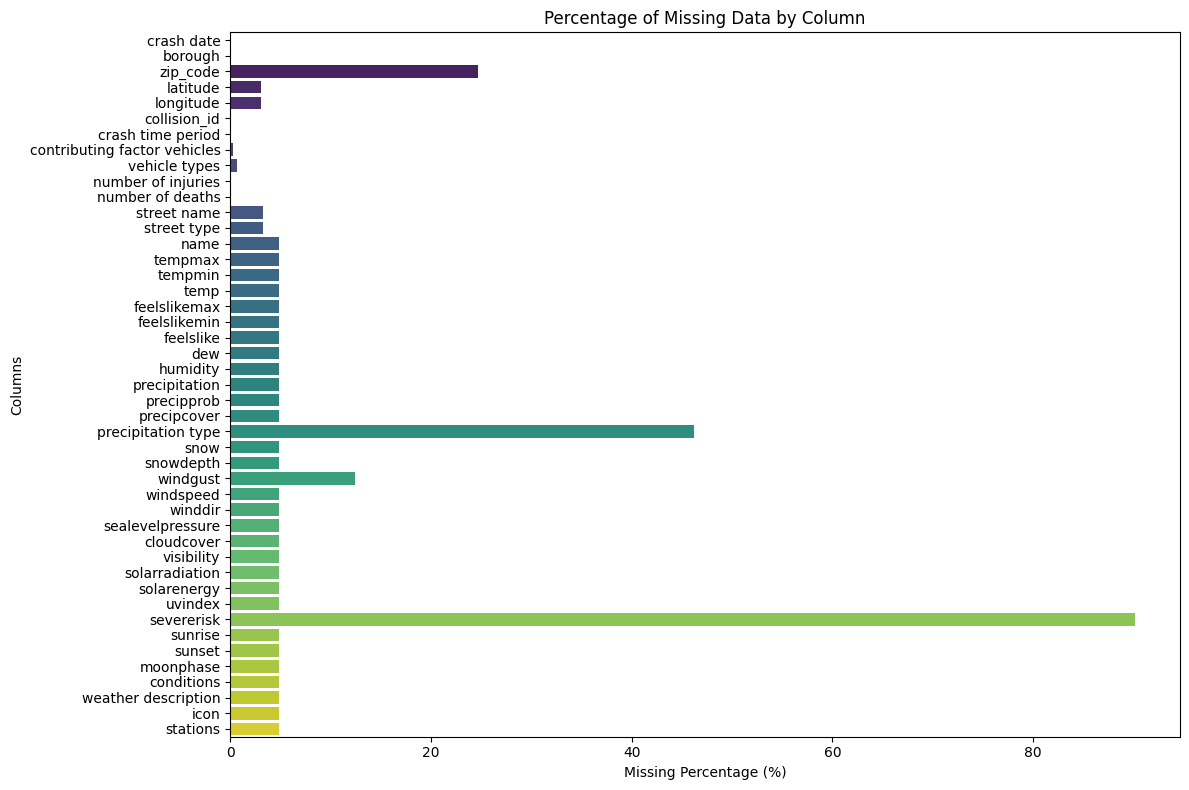

In [25]:
from pyspark.sql.functions import col, count, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate missing percentages
missing_data = {
    c: (1 - (final_data_viz.filter(col(c).isNotNull()).count() / final_data_viz.count())) * 100
    for c in final_data_viz.columns
}

# Convert the missing data dictionary to a Pandas DataFrame
missing_percent_df = pd.DataFrame(
    {'Column': list(missing_data.keys()), 'Missing Percentage': list(missing_data.values())}
)

# Plot the missing data as a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=missing_percent_df, x='Missing Percentage', y='Column', palette='viridis')
plt.title('Percentage of Missing Data by Column')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()


<ipython-input-44-98efe5449750>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_counts_pd, x="BOROUGH", y="count", palette="husl")


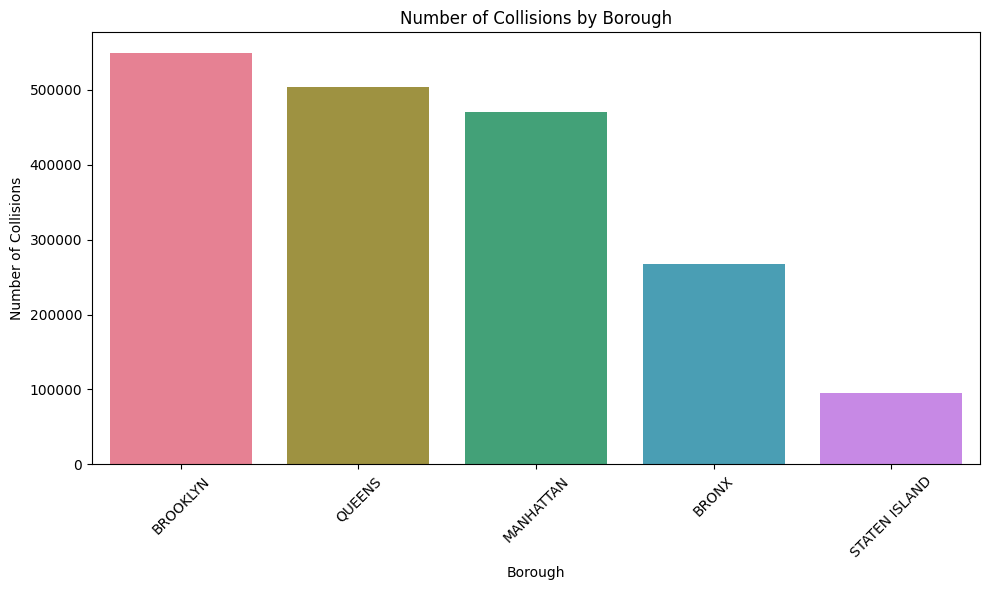

In [44]:
from pyspark.sql.functions import col, trim, upper

# Standardize the BOROUGH column and remove "OFF STREET"
final_data_viz = final_data_viz.withColumn("BOROUGH", upper(trim(col("BOROUGH"))))
final_data_viz = final_data_viz.filter(final_data_viz["BOROUGH"] != "OFF STREET")

# Count collisions per borough
borough_counts = final_data_viz.groupBy("BOROUGH").count().orderBy("count", ascending=False)

# Convert to Pandas for visualization
borough_counts_pd = borough_counts.toPandas()

# Plot the collision count (vertical bars)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=borough_counts_pd, x="BOROUGH", y="count", palette="husl")
plt.title("Number of Collisions by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Collisions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


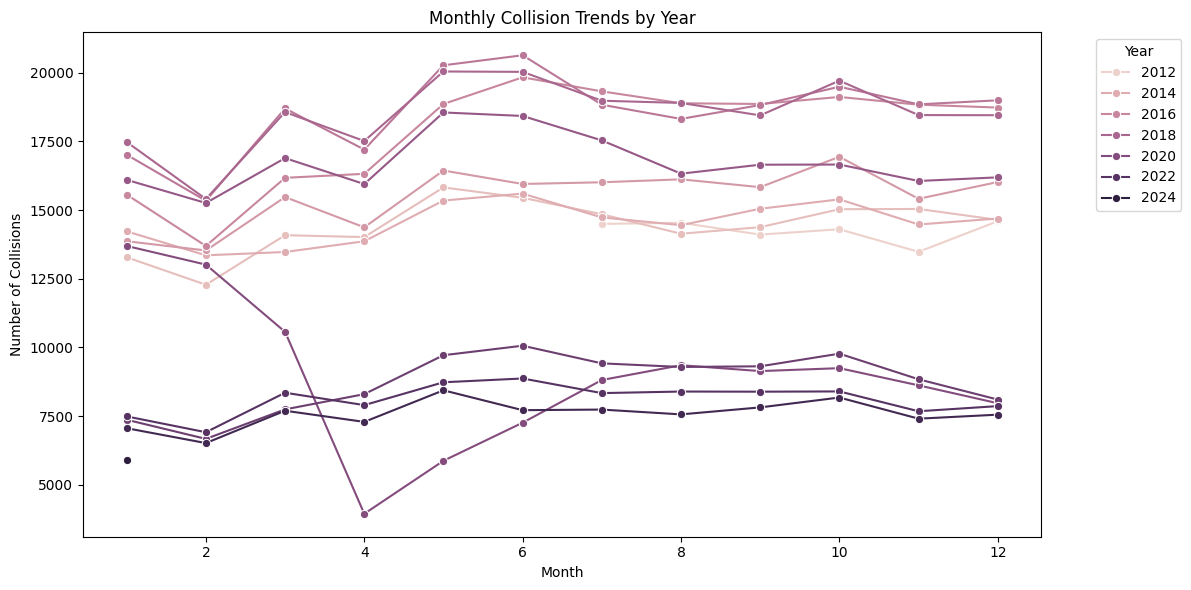

In [29]:
# 3. Temporal Analysis of Collisions (by Date)
from pyspark.sql.functions import year, month

# Extract year and month
temporal_data = final_data_viz.withColumn('Year', year(col('CRASH DATE'))).withColumn('Month', month(col('CRASH DATE')))

# Count collisions per year and month
monthly_trend = temporal_data.groupBy('Year', 'Month').count().orderBy('Year', 'Month')

# Convert to Pandas for visualization
monthly_trend_pd = monthly_trend.toPandas()

# Plot the monthly trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trend_pd, x='Month', y='count', hue='Year', marker='o')
plt.title('Monthly Collision Trends by Year')
plt.xlabel('Month')
plt.ylabel('Number of Collisions')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-32-ddb441f85c4b>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_weather, x='Percentage', y='conditions', palette='Blues_r')


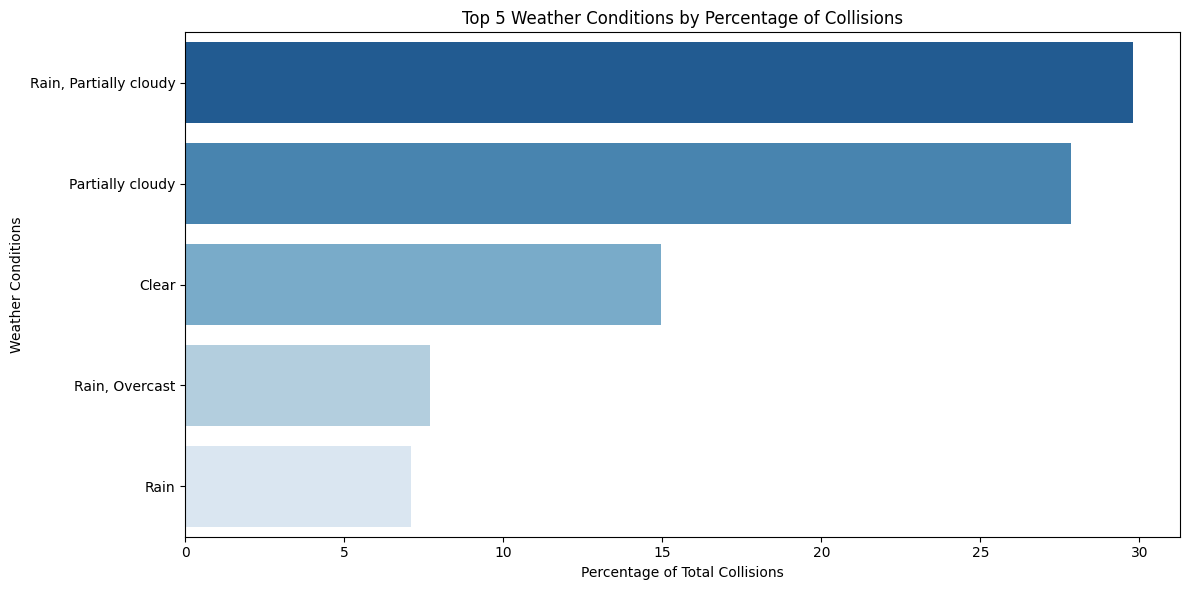

In [32]:
# 4. Weather Conditions vs Collisions
# Calculate collision counts and percentages by condition
weather_counts = final_data_viz.groupBy("conditions").count()
total_collisions = final_data_viz.count()

weather_percentages = weather_counts.withColumn(
    "Percentage", (col("count") / total_collisions) * 100
).orderBy("Percentage", ascending=False)

# Convert to Pandas for visualization
weather_percentages_pd = weather_percentages.toPandas()

# Plot the top weather conditions
top_weather = weather_percentages_pd.head(5)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_weather, x='Percentage', y='conditions', palette='Blues_r')
plt.title('Top 5 Weather Conditions by Percentage of Collisions')
plt.xlabel('Percentage of Total Collisions')
plt.ylabel('Weather Conditions')
plt.tight_layout()
plt.show()


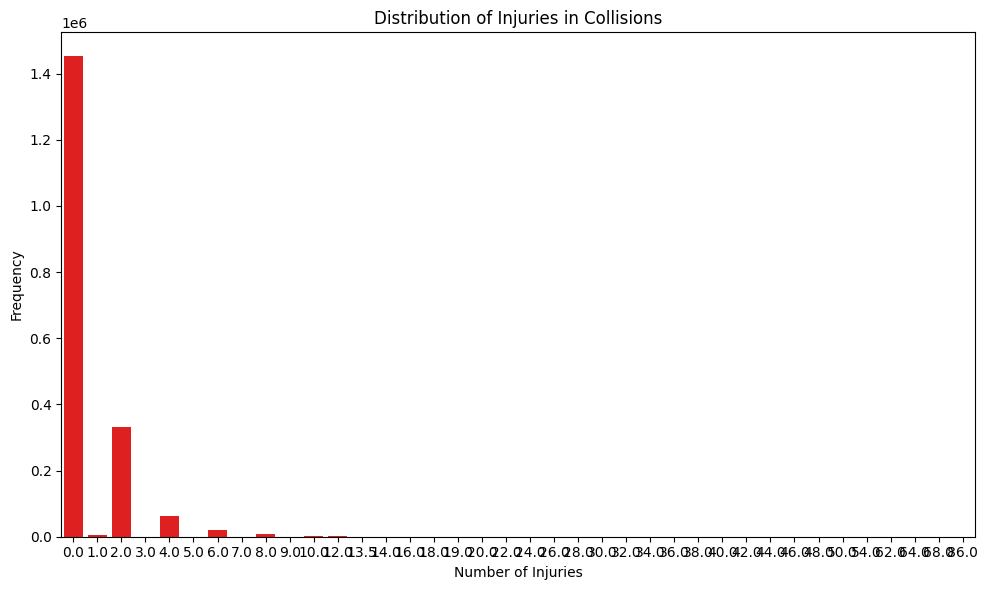

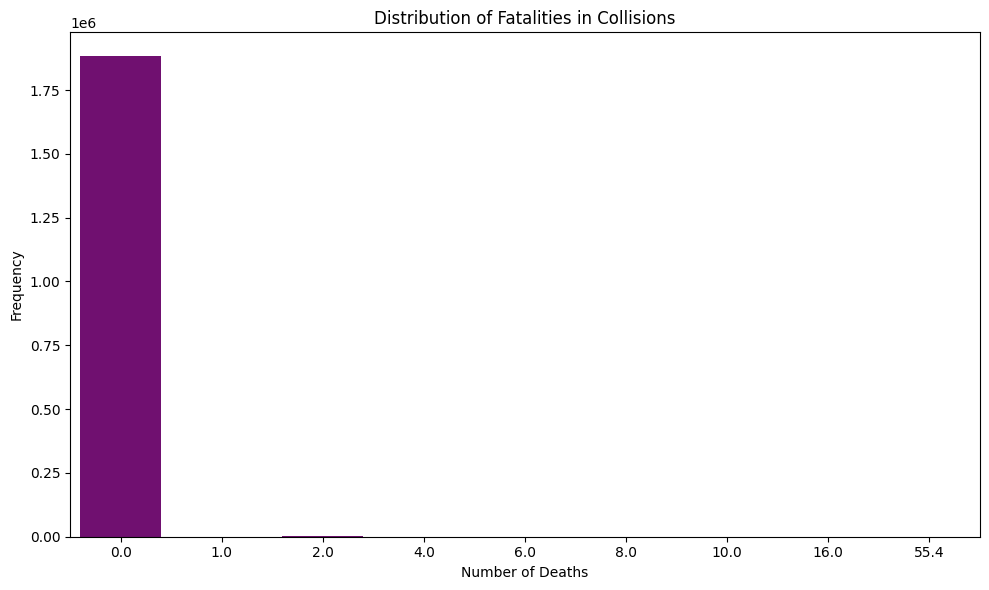

In [34]:
# 5. Severity Analysis (Injuries and Fatalities)
from pyspark.sql.functions import col

# Aggregate injury and death counts
injury_data = final_data_viz.groupBy("number of injuries").count().orderBy("number of injuries")
death_data = final_data_viz.groupBy("number of deaths").count().orderBy("number of deaths")

# Convert to Pandas for visualization
injury_data_pd = injury_data.toPandas()
death_data_pd = death_data.toPandas()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=injury_data_pd, x="number of injuries", y="count", color="red")
plt.title("Distribution of Injuries in Collisions")
plt.xlabel("Number of Injuries")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=death_data_pd, x="number of deaths", y="count", color="purple")
plt.title("Distribution of Fatalities in Collisions")
plt.xlabel("Number of Deaths")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Summary of Visualizations

## 1. Percentage of Missing Data by Column
- Significant missing data in columns like `Precipitation Type` and `Severe Risk`.
- Data imputation or removal is necessary for handling these columns.

---

## 2. Number of Collisions by Borough
- **Brooklyn** has the highest number of collisions, followed by **Queens** and **Manhattan**.
- **Staten Island** has the lowest number of collisions.

---

## 3. Monthly Collision Trends by Year
- Collisions peak during **summer months (June to August)** and decrease in **winter months**.
- An increasing trend in collisions is observed over the years.

---

## 4. Top 5 Weather Conditions by Percentage of Collisions
- **Rain with Partial Clouds** and **Partly Cloudy Weather** contribute the most to collisions.
- Clear weather conditions also account for a significant portion of accidents.

---

## 5. Distribution of Injuries in Collisions
- Most collisions result in **0-2 injuries**.
- Higher numbers of injuries are rare but significant when they occur.

---

## 6. Distribution of Fatalities in Collisions
- The majority of collisions result in **0 fatalities**.
- Multiple-fatality incidents are rare but require critical attention.

---



##Data Preparation (More)

In [ ]:
# Define the list of columns to drop
columns_to_drop = [
    "severerisk",
    "precipitation type",
    "name",
    "stations",
    "moonphase",
    "icon",
    "street type",
    "contributing factor vehicles",
    "vehicle types",
    "number of injuries",
    "number of deaths",
    "tempmax",
    "tempmin",
    "feelslikemax",
    "feelslikemin",
    "precipprob",
    "precipcover",
    "solarradiation",
    "solarenergy",
    "sealevelpressure",
    "street name",
    "cloudcover"
]

# Drop the columns
final_data = final_data.drop(*columns_to_drop)

# Display the updated schema to verify
final_data.printSchema()


root
 |-- crash date: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- crash time period: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: string (nullable = true)
 |-- windgust: string (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: string (nullable = true)
 |-- visibility: string (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)



In [ ]:
# Columns to check for missing data
columns_to_drop_missing = [
    "latitude", "longitude", "zip_code","temp",  "feelslike", "dew", "humidity",
    "precipitation", "snow", "snowdepth", "windspeed", "winddir", "windgust",
     "visibility",  "uvindex", "sunrise", "sunset", "conditions", "weather description"
]

# Drop rows where any of these columns are missing
final_data_cleaned = final_data.filter(
    ~(
        sum([col(c).isNull().cast("int") for c in columns_to_drop_missing]) > 0
    )
)

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum

# Row count for the final dataset
row_count = final_data_cleaned.count()

# Calculate missing data percentage for each column
missing_data = (
    final_data_cleaned.select([(spark_sum(col(c).isNull().cast("int")) / row_count).alias(c) for c in final_data_cleaned.columns])
    .toPandas()
    .T.reset_index()
)

# Rename columns for clarity
missing_data.columns = ["Column", "Missing_Percentage"]

# Add total row count to the output
missing_data["Total_Rows"] = row_count

# Display the results
missing_data

Column  Missing_Percentage  Total_Rows
0            crash date                 0.0     1195588
1               borough                 0.0     1195588
2              zip_code                 0.0     1195588
3              latitude                 0.0     1195588
4             longitude                 0.0     1195588
5          collision_id                 0.0     1195588
6     crash time period                 0.0     1195588
7                  temp                 0.0     1195588
8             feelslike                 0.0     1195588
9                   dew                 0.0     1195588
10             humidity                 0.0     1195588
11        precipitation                 0.0     1195588
12                 snow                 0.0     1195588
13            snowdepth                 0.0     1195588
14             windgust                 0.0     1195588
15            windspeed                 0.0     1195588
16              winddir                 0.0     1195588
17           visibility                 0.0     1195588
18              uvindex                 0.0     1195588
19              sunrise                 0.0     1195588
20               sunset                 0.0     1195588
21           conditions                 0.0     1195588
22  weather description                 0.0     1195588

In [ ]:
# Display all columns with their data types
for col_name, data_type in final_data_cleaned.dtypes:
    print(f"Column: {col_name}, Type: {data_type}")


Column: crash date, Type: string
Column: borough, Type: string
Column: zip_code, Type: string
Column: latitude, Type: double
Column: longitude, Type: double
Column: collision_id, Type: double
Column: crash time period, Type: string
Column: temp, Type: double
Column: feelslike, Type: double
Column: dew, Type: double
Column: humidity, Type: double
Column: precipitation, Type: double
Column: snow, Type: double
Column: snowdepth, Type: string
Column: windgust, Type: string
Column: windspeed, Type: double
Column: winddir, Type: string
Column: visibility, Type: string
Column: uvindex, Type: double
Column: sunrise, Type: timestamp
Column: sunset, Type: timestamp
Column: conditions, Type: string
Column: weather description, Type: string


In [ ]:
from pyspark.sql.functions import col

# Convert specified columns from string to double
columns_to_convert = ["snowdepth", "windgust", "winddir", "visibility"]

# Loop through the columns and cast them to double
for column in columns_to_convert:
    final_data_cleaned = final_data_cleaned.withColumn(column, col(column).cast("double"))

# Verify the schema after conversion
final_data_cleaned.printSchema()

root
 |-- crash date: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- crash time period: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)



In [ ]:
from pyspark.sql.functions import to_date, to_timestamp, concat_ws, lit

# Convert 'crash date' to date type
final_data_cleaned = final_data_cleaned.withColumn("crash date", to_date(col("crash date"), "yyyy-MM-dd"))

# Convert 'crash time period' to timestamp type
# we'll create a timestamp by combining with the 'crash date'
final_data_cleaned = final_data_cleaned.withColumn(
    "crash time period",
    to_timestamp(concat_ws(" ", col("crash date").cast("string"), col("crash time period").substr(0, 5)), "yyyy-MM-dd HH:mm")
)

# Verify the schema
final_data_cleaned.printSchema()


root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- crash time period: timestamp (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)



In [ ]:
# Show the result
final_data_cleaned.show(5)

+----------+---------+--------+---------+----------+------------+-------------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------+--------------------+
|crash date|  borough|zip_code| latitude| longitude|collision_id|  crash time period|temp|feelslike| dew|humidity|precipitation|snow|snowdepth|windgust|windspeed|winddir|visibility|uvindex|            sunrise|             sunset|conditions| weather description|
+----------+---------+--------+---------+----------+------------+-------------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------+--------------------+
|2021-09-11| BROOKLYN|   11208|40.667202|  -73.8665|   4456314.0|2021-09-11 09:00:00|22.0|     22.0|12.6|    56.0|         0.23| 0.0|      0.0|    86.8|     20.6|  251.6|      15.9|    8.0|2021-09-11 06:32:59|2021-

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Specify the columns for which to calculate correlation (numeric columns only)
columns_to_check = [
    "latitude", "longitude", "temp", "feelslike", "dew", "humidity",
    "precipitation", "snow", "snowdepth", "windspeed", "uvindex"
]

# Filter numeric columns based on their types in the schema
numeric_columns = [
    c for c in columns_to_check if final_data_cleaned.schema[c].dataType.simpleString() in ["double", "float"]
]

# Assemble the selected numeric columns into a feature vector
vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
data_with_features = vector_assembler.transform(final_data_cleaned).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(data_with_features, "features").head()[0].toArray()

# Create a Pandas DataFrame for better visualization
import pandas as pd

correlation_df = pd.DataFrame(
    correlation_matrix,
    columns=numeric_columns,
    index=numeric_columns
)

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_df)


Correlation Matrix:
               latitude  longitude      temp  feelslike       dew  humidity  \
latitude       1.000000  -0.998752  0.007053   0.005731  0.008670  0.004266   
longitude     -0.998752   1.000000 -0.006869  -0.005528 -0.008477 -0.004178   
temp           0.007053  -0.006869  1.000000   0.997205  0.941346  0.205263   
feelslike      0.005731  -0.005528  0.997205   1.000000  0.941113  0.212380   
dew            0.008670  -0.008477  0.941346   0.941113  1.000000  0.519506   
humidity       0.004266  -0.004178  0.205263   0.212380  0.519506  1.000000   
precipitation  0.010533  -0.010804 -0.002336  -0.001546  0.138160  0.446546   
snow           0.005062  -0.005079 -0.208603  -0.217857 -0.169424  0.042432   
snowdepth      0.006814  -0.006799 -0.229828  -0.234922 -0.203526 -0.012253   
windspeed      0.000061  -0.000348 -0.269995  -0.290820 -0.241265  0.001821   
uvindex       -0.003314   0.003374  0.507134   0.500624  0.300701 -0.414226   

               precipitation   

In [ ]:
# Assuming final_data_cleaned is your DataFrame
# Convert the PySpark DataFrame to a Pandas DataFrame for easier export
final_data_pandas = final_data_cleaned.toPandas()

# Save it as a CSV file
final_data_pandas.to_csv("final_data_cleaned.csv", index=False)

# Code to download the file in a notebook environment (e.g., in Google Colab)
from google.colab import files
files.download("final_data_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Load CSV").getOrCreate()

# Load the CSV file into a PySpark DataFrame
final_data_cleaned = spark.read.csv("/content/final_data_cleaned.csv", header=True, inferSchema=True)

# Verify the schema and data
final_data_cleaned.printSchema()
final_data_cleaned.show(5)


root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- crash time period: timestamp (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)

+----------+---------+--------+---------+------

In [ ]:
# Get the number of rows
row_count = final_data_cleaned.count()

# Get the number of columns
column_count = len(final_data_cleaned.columns)

# Print the results
print(f"Number of Rows: {row_count}")
print(f"Number of Columns: {column_count}")

Number of Rows: 1195588
Number of Columns: 23


In [ ]:
# Sort the DataFrame based on crash date
sorted_data = final_data_cleaned.orderBy("crash date")

# Show the first few rows to verify
sorted_data.show(5)

# Replace final_data_cleaned with the sorted DataFrame if needed
final_data_cleaned = sorted_data


+----------+-------------+--------+----------+-----------+------------+-------------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------------+--------------------+
|crash date|      borough|zip_code|  latitude|  longitude|collision_id|  crash time period|temp|feelslike| dew|humidity|precipitation|snow|snowdepth|windgust|windspeed|winddir|visibility|uvindex|            sunrise|             sunset|      conditions| weather description|
+----------+-------------+--------+----------+-----------+------------+-------------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------------+--------------------+
|2013-01-01|STATEN ISLAND|   10314|40.6080537|-74.1573526|    295919.0|2013-01-01 00:00:00| 2.7|     -1.3|-5.3|    55.8|          0.0| 0.0|      0.0|    44.3|     35.0|  283.3|  

In [ ]:
from pyspark.sql.functions import col, year, month, dayofweek, hour, when, regexp_extract

# Step 1: Extract the hour from the "crash time period"
# Use regex to extract the hour component from the time
final_data_time = final_data_cleaned.withColumn("hour", regexp_extract(col("crash time period"), r"(\d{2}):\d{2}:\d{2}", 1).cast("int"))

# Step 2: Create the "time_bucket" based on the extracted hour
final_data_time = final_data_time.withColumn(
    "time_bucket",
    when((col("hour") >= 0) & (col("hour") < 6), "Night")
    .when((col("hour") >= 6) & (col("hour") < 12), "Morning")
    .when((col("hour") >= 12) & (col("hour") < 18), "Afternoon")
    .when((col("hour") >= 18) & (col("hour") < 24), "Evening")
    .otherwise("Unknown")  # Default case for unexpected values
).drop("hour")  # Drop the intermediate "hour" column

# Step 3: Extract additional date-related features
final_data_time = final_data_time.withColumn("year", year(col("crash date"))) \
    .withColumn("month", month(col("crash date"))) \
    .withColumn("day_of_week", dayofweek(col("crash date")))

# Step 4: Drop the original "crash time period" column
final_data_time = final_data_time.drop("crash time period")

# Step 5: Verify the extracted features
final_data_time.select("crash date", "year", "month", "day_of_week", "time_bucket").show(10, truncate=False)


+----------+----+-----+-----------+-----------+
|crash date|year|month|day_of_week|time_bucket|
+----------+----+-----+-----------+-----------+
|2013-01-01|2013|1    |3          |Morning    |
|2013-01-01|2013|1    |3          |Night      |
|2013-01-01|2013|1    |3          |Morning    |
|2013-01-01|2013|1    |3          |Night      |
|2013-01-01|2013|1    |3          |Afternoon  |
|2013-01-01|2013|1    |3          |Night      |
|2013-01-01|2013|1    |3          |Morning    |
|2013-01-01|2013|1    |3          |Night      |
|2013-01-01|2013|1    |3          |Afternoon  |
|2013-01-01|2013|1    |3          |Afternoon  |
+----------+----+-----+-----------+-----------+
only showing top 10 rows



In [ ]:
from pyspark.sql.types import StringType

# Identify categorical columns
categorical_columns = [field.name for field in final_data_time.schema.fields if isinstance(field.dataType, StringType)]

# Display the list of categorical columns
print(f"Categorical Columns: {categorical_columns}")


Categorical Columns: ['borough', 'zip_code', 'conditions', 'weather description', 'time_bucket']


In [ ]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import col

# Step 1: Identify categorical columns (columns with StringType)
categorical_columns = [
    field.name for field in final_data_time.schema.fields if isinstance(field.dataType, StringType)
]

# Step 2: Calculate unique value counts for each categorical column
unique_value_counts = []
for col_name in categorical_columns:
    unique_count = final_data_time.select(col_name).distinct().count()
    unique_value_counts.append((col_name, unique_count))

# Step 3: Create a DataFrame to display results
unique_value_df = spark.createDataFrame(unique_value_counts, ["Column", "Unique_Count"])

# Step 4: Show the unique value counts for categorical columns
unique_value_df.show(truncate=False)


+-------------------+------------+
|Column             |Unique_Count|
+-------------------+------------+
|borough            |5           |
|zip_code           |234         |
|conditions         |19          |
|weather description|94          |
|time_bucket        |4           |
+-------------------+------------+



In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# **Step 1: One-Hot Encoding for Low Cardinality Columns**
low_cardinality_cols = ["borough", "time_bucket"]

# Create StringIndexer and OneHotEncoder for low cardinality columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in low_cardinality_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") for col in low_cardinality_cols]

# Build a pipeline for one-hot encoding
ohe_pipeline = Pipeline(stages=indexers + encoders)
final_data_time = ohe_pipeline.fit(final_data_time).transform(final_data_time)

# **Step 2: Label Encoding for Medium Cardinality Columns**
medium_cardinality_cols = ["zip_code", "conditions", "weather description"]

# Create StringIndexer for medium cardinality columns
label_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in medium_cardinality_cols]

# Apply label encoding via a pipeline
label_pipeline = Pipeline(stages=label_indexers)
final_data_time = label_pipeline.fit(final_data_time).transform(final_data_time)

Final DataFrame Schema:
root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)
 |-- time_bucket: string (nullable = false)
 |-- year: integer (nullable = t

In [ ]:
# Rename
final_data_cat_encode = final_data_time

print("Final DataFrame Schema:")
final_data_cat_encode.printSchema()

Final DataFrame Schema:
root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)
 |-- time_bucket: string (nullable = false)
 |-- year: integer (nullable = t

In [ ]:
# Show the result
final_data_cat_encode.show(5)

+----------+-------------+--------+----------+-----------+------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------------+--------------------+-----------+----+-----+-----------+-------------+-----------------+-------------+---------------+--------------+----------------+-------------------------+
|crash date|      borough|zip_code|  latitude|  longitude|collision_id|temp|feelslike| dew|humidity|precipitation|snow|snowdepth|windgust|windspeed|winddir|visibility|uvindex|            sunrise|             sunset|      conditions| weather description|time_bucket|year|month|day_of_week|borough_index|time_bucket_index|  borough_ohe|time_bucket_ohe|zip_code_index|conditions_index|weather description_index|
+----------+-------------+--------+----------+-----------+------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame for easier export
final_data_pandas = final_data_cat_encode.toPandas()

# Save it as a CSV file
final_data_pandas.to_csv("final_data_cat_encode.csv", index=False)

# Code to download the file in a notebook environment (e.g., in Google Colab)
from google.colab import files
files.download("final_data_cat_encode.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Load CSV").getOrCreate()

# Load the CSV file into a PySpark DataFrame
final_data_cat_encode = spark.read.csv("/content/final_data_cat_encode.csv", header=True, inferSchema=True)

# Verify the schema and data
final_data_cat_encode.printSchema()
final_data_cat_encode.show(5)

# Get the number of rows
row_count = final_data_cat_encode.count()

# Get the number of columns
column_count = len(final_data_cat_encode.columns)

# Print the results
print(f"Number of Rows: {row_count}")
print(f"Number of Columns: {column_count}")


root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)
 |-- time_bucket: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer 

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import col

# Select numeric columns to scale
numeric_columns = [
    "latitude", "longitude", "temp", "feelslike", "dew", "humidity",
    "precipitation", "snow", "snowdepth", "windgust", "windspeed",
    "winddir", "visibility", "uvindex"
]

# Step 1: Assemble numeric columns into a vector
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features_vector")
assembled_data = assembler.transform(final_data_cat_encode)

# Step 2: Apply MinMaxScaler (scales data to [0, 1])
scaler = MinMaxScaler(inputCol="features_vector", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Step 3: Replace original numeric columns with scaled data or create new columns
# Extract scaled features back into individual columns
from pyspark.ml.functions import vector_to_array

scaled_data = scaled_data.withColumn("scaled_array", vector_to_array(col("scaled_features")))

# Create new columns for scaled features
for i, col_name in enumerate(numeric_columns):
    scaled_data = scaled_data.withColumn(f"{col_name}_scaled", col("scaled_array")[i])

# Drop intermediate columns
scaled_data = scaled_data.drop("features_vector", "scaled_features", "scaled_array")

# Show results
scaled_data.select([col for col in scaled_data.columns if "_scaled" in col]).show(5)

# Save or use `scaled_data` for modeling


+------------------+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-----------+----------------+-------------------+------------------+------------------+-----------------+--------------+
|   latitude_scaled|    longitude_scaled|       temp_scaled|   feelslike_scaled|        dew_scaled|    humidity_scaled|precipitation_scaled|snow_scaled|snowdepth_scaled|    windgust_scaled|  windspeed_scaled|    winddir_scaled|visibility_scaled|uvindex_scaled|
+------------------+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-----------+----------------+-------------------+------------------+------------------+-----------------+--------------+
|0.9885159782765953|0.003323594814407...|0.3473451327433628|0.36073825503355705|0.4128256513026052|0.44016506189821175|                 0.0|        0.0|             0.0|0.30876865671641784|0.5603271983640081|0.7872636

In [ ]:
# Show the result
scaled_data.show(5)

+----------+-------------+--------+----------+-----------+------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------------+--------------------+-----------+----+-----+-----------+-------------+-----------------+-------------+---------------+--------------+----------------+-------------------------+------------------+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-----------+----------------+-------------------+------------------+------------------+-----------------+--------------+
|crash date|      borough|zip_code|  latitude|  longitude|collision_id|temp|feelslike| dew|humidity|precipitation|snow|snowdepth|windgust|windspeed|winddir|visibility|uvindex|            sunrise|             sunset|      conditions| weather description|time_bucket|year|month|day_of_week|borough_index|time_bucket_index|  borough_oh

In [ ]:
# Convert the scaled PySpark DataFrame to a Pandas DataFrame
scaled_data_pandas = scaled_data.toPandas()

# Save it as a CSV file
scaled_data_pandas.to_csv("scaled_final_data.csv", index=False)

# Code to download the file in a notebook environment (e.g., Google Colab)
from google.colab import files
files.download("scaled_final_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Load Scaled CSV").getOrCreate()

# Load the scaled CSV file into a PySpark DataFrame
final_data = spark.read.csv("/content/scaled_final_data.csv", header=True, inferSchema=True)

# Verify the schema and data
final_data.printSchema()
final_data.show(5)

# Get the number of rows
row_count = final_data.count()

# Get the number of columns
column_count = len(final_data.columns)

# Print the results
print(f"Number of Rows: {row_count}")
print(f"Number of Columns: {column_count}")


root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)
 |-- time_bucket: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer 

## Section Explanation

### **Dropping Unnecessary Columns**
- **Defined a list of columns to drop** to reduce noise in the dataset and focus on relevant attributes for analysis:
  - Removed weather-related fields with high missing percentages (e.g., `severerisk`, `precipitation type`).
  - Eliminated redundant fields (e.g., `street name`, `vehicle types`, `number of injuries`, `number of deaths`).
- **Dropped the columns** from the dataset using PySpark's `drop` method.
- **Verified the updated schema** to ensure only relevant columns were retained.

---

### **Handling Missing Data**
- Identified columns critical for analysis, such as `latitude`, `longitude`, `zip_code`, and weather-related attributes.
- **Filtered rows with missing values** in these columns to ensure the dataset was complete for downstream tasks.
- **Recalculated missing value percentages** to validate data quality:
  - Missing data was eliminated for selected critical columns.
  - Resulting dataset had **1,195,588 rows** and **23 columns**.

---

### **Data Type Conversion**
- **Converted column data types** where necessary:
  - Converted categorical columns (e.g., `borough`, `zip_code`) to appropriate types for encoding.
  - Ensured numeric columns were in `double` format for scaling and analysis.

---

### **Date and Time Feature Engineering**
- Extracted and transformed the `crash date` and `crash time period` columns:
  - Converted `crash date` to a `date` type.
  - Combined `crash date` and time details from `crash time period` to create a `timestamp`.
- **Derived additional features**:
  - Extracted `year`, `month`, `day_of_week`, and `time_bucket` (e.g., Morning, Afternoon, Evening, Night).
  - Dropped intermediate and redundant columns after feature extraction.

---

### **Categorical Encoding**
- Identified categorical columns (`borough`, `zip_code`, `conditions`, `weather description`, `time_bucket`).
- Applied:
  - **One-Hot Encoding** for low-cardinality columns (`borough`, `time_bucket`).
  - **Label Encoding** for medium-cardinality columns (`zip_code`, `conditions`, `weather description`).
- Verified the encoded columns were added to the dataset and retained both encoded and original categorical data for flexibility.

---

### **Numeric Feature Scaling**
- Selected numeric columns for scaling, such as `latitude`, `longitude`, `temp`, `humidity`, and `windspeed`.
- **Normalized numeric features** to a range of [0, 1] using MinMaxScaler for uniformity in machine learning models.
- Created scaled columns and verified their correctness while retaining the original data.

---

### **Final Data Export**
- **Saved the cleaned, encoded, and scaled dataset** to a CSV file (`scaled_final_data.csv`).
- Ensured compatibility for future analysis by exporting the dataset in both PySpark and Pandas formats.

---

### **Key Results**
1. **Dataset Dimensions**:
   - After cleaning and transformation:
     - **Rows**: 1,195,588
     - **Columns**: 33
2. **Data Quality**:
   - Missing values were eliminated for critical columns.
   - Features were enriched with temporal and categorical encodings.
3. **Feature Preparation**:
   - Numeric features were normalized for compatibility with ML models.
   - Categorical features were encoded for downstream tasks.

---

### **Why These Steps Were Taken**
- **Data Simplification**: Dropping unnecessary columns reduced noise and improved focus on critical features.
- **Completeness**: Eliminated missing values for essential columns to ensure data integrity.
- **Feature Engineering**: Enhanced the dataset with derived features like `time_bucket`, ensuring richer temporal analysis.
- **Scalability**: Prepared the dataset for machine learning pipelines with categorical encoding and feature scaling.
- **Efficiency**: PySpark's distributed capabilities ensured smooth processing of the large dataset.

This prepared dataset is now ready for predictive modeling and advanced analysis tasks.


##Data Modelling

####Linear Regression (Weekly Forecasting)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, weekofyear, avg, count, when, lit, col, abs as abs_diff, sqrt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Add temporal features and aggregate weekly data by borough
weekly_data = final_data_cat_encode.withColumn("crash_year", year(col("crash date"))) \
    .withColumn("crash_week", weekofyear(col("crash date"))) \
    .groupBy("borough", "crash_year", "crash_week") \
    .agg(
        count("collision_id").alias("num_accidents"),
        avg("temp").alias("avg_temp"),
        avg("humidity").alias("avg_humidity"),
        avg("precipitation").alias("avg_precipitation"),
        avg("windspeed").alias("avg_windspeed"),
        avg("conditions_index").alias("avg_conditions_index"),
        avg("weather description_index").alias("avg_weather_description_index")
    )

# Display the aggregated data
weekly_data.show(5)

+-------------+----------+----------+-------------+------------------+------------------+--------------------+------------------+--------------------+-----------------------------+
|      borough|crash_year|crash_week|num_accidents|          avg_temp|      avg_humidity|   avg_precipitation|     avg_windspeed|avg_conditions_index|avg_weather_description_index|
+-------------+----------+----------+-------------+------------------+------------------+--------------------+------------------+--------------------+-----------------------------+
|STATEN ISLAND|      2013|         1|          153|0.9588235294117663|54.228758169934686|                 0.0|26.507189542483687|                 1.0|            2.104575163398693|
|        BRONX|      2016|        17|          103|11.164077669902916| 61.47961165048545|  1.8381650485436856|18.815533980582543|  1.1359223300970873|            8.330097087378642|
|STATEN ISLAND|      2013|        14|          171| 6.293567251462002| 41.16959064327486|0.0235

In [ ]:
# Add weights based on crash_year
weekly_data = weekly_data.withColumn(
    "weight",
    when(weekly_data.crash_year == 2022, lit(1.8))
    .when(weekly_data.crash_year == 2021, lit(1.8))
    .when(weekly_data.crash_year == 2020, lit(1.0))
    .otherwise(lit(0.5))
)

# Display data with weights
weekly_data.select("borough", "crash_year", "crash_week", "num_accidents", "weight").show(5)


+-------------+----------+----------+-------------+------+
|      borough|crash_year|crash_week|num_accidents|weight|
+-------------+----------+----------+-------------+------+
|STATEN ISLAND|      2013|         1|          153|   0.5|
|        BRONX|      2016|        17|          103|   0.5|
|STATEN ISLAND|      2013|        14|          171|   0.5|
|STATEN ISLAND|      2013|        28|          111|   0.5|
|    MANHATTAN|      2013|        43|          844|   0.5|
+-------------+----------+----------+-------------+------+
only showing top 5 rows



In [ ]:
# Split the data into training and testing datasets
train_data = weekly_data.filter(weekly_data.crash_year < 2023)  # Train on pre-2023 data
test_data = weekly_data.filter(weekly_data.crash_year == 2023)  # Predict for 2023

# Display the splits
print("Training Data:")
train_data.show(5)

print("Testing Data:")
test_data.show(5)


Training Data:
+-------------+----------+----------+-------------+------------------+------------------+--------------------+------------------+--------------------+-----------------------------+------+
|      borough|crash_year|crash_week|num_accidents|          avg_temp|      avg_humidity|   avg_precipitation|     avg_windspeed|avg_conditions_index|avg_weather_description_index|weight|
+-------------+----------+----------+-------------+------------------+------------------+--------------------+------------------+--------------------+-----------------------------+------+
|STATEN ISLAND|      2013|         1|          153|0.9588235294117663|54.228758169934686|                 0.0|26.507189542483687|                 1.0|            2.104575163398693|   0.5|
|        BRONX|      2016|        17|          103|11.164077669902916| 61.47961165048545|  1.8381650485436856|18.815533980582543|  1.1359223300970873|            8.330097087378642|   0.5|
|STATEN ISLAND|      2013|        14|        

In [ ]:
# List of features for the model
feature_columns = [
    "avg_temp", "avg_humidity", "avg_precipitation",
    "avg_windspeed", "avg_conditions_index", "avg_weather_description_index"
]

# Assemble features for training and testing
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

train_data = assembler.transform(train_data).select("borough", "features", "num_accidents", "weight").withColumnRenamed("num_accidents", "label")
test_data = assembler.transform(test_data).select("borough", "features", "num_accidents").withColumnRenamed("num_accidents", "label")


In [ ]:
# Train the model for each borough
models = {}
boroughs = train_data.select("borough").distinct().collect()

for borough in boroughs:
    borough_name = borough["borough"]
    borough_train_data = train_data.filter(train_data.borough == borough_name)

    lr = LinearRegression(featuresCol="features", labelCol="label", weightCol="weight")
    models[borough_name] = lr.fit(borough_train_data)

# Display model coefficients and intercept for each borough
for borough_name, model in models.items():
    print(f"Borough: {borough_name}")
    print(f"Coefficients: {model.coefficients}")
    print(f"Intercept: {model.intercept}")


Borough: QUEENS
Coefficients: [4.480736742915547,-4.320368983072843,21.656233917478254,7.888161961210865,8.1607827149499,4.306266405931094]
Intercept: 423.4344115886064
Borough: BROOKLYN
Coefficients: [6.413461790864388,-5.800560140783738,23.311913425812136,9.395058953658689,15.340710727881909,4.403426957452438]
Intercept: 540.7305242785756
Borough: BRONX
Coefficients: [2.8991131124880782,-2.0323240573733705,9.265377808071587,3.3157980382668812,7.176611068195282,2.190981201488931]
Intercept: 246.34302573893478
Borough: MANHATTAN
Coefficients: [5.282876554487089,-7.281423643683714,27.88326323357976,9.953205378138193,6.489630189615233,1.8000273669244835]
Intercept: 448.33126916914824
Borough: STATEN ISLAND
Coefficients: [0.7428533546034551,-1.0107972179726887,4.763661717115205,1.9354616331908387,3.0117142709880502,0.35340326859822807]
Intercept: 63.73338675637871


In [ ]:
# Predict for 2023 and evaluate the model for each borough
for borough in boroughs:
    borough_name = borough["borough"]
    borough_test_data = test_data.filter(test_data.borough == borough_name)

    predictions = models[borough_name].transform(borough_test_data)

    # Calculate errors
    predictions = predictions.withColumn("error", abs_diff(col("label") - col("prediction"))) \
        .withColumn("squared_error", (col("label") - col("prediction")) ** 2)

    # Compute MAE and RMSE
    mae = predictions.select(avg("error")).first()[0]
    rmse = predictions.select(sqrt(avg("squared_error"))).first()[0]

    print(f"Borough: {borough_name}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")


Borough: QUEENS
Mean Absolute Error (MAE): 120.81444677568263
Root Mean Squared Error (RMSE): 147.70013040950838
Borough: BROOKLYN
Mean Absolute Error (MAE): 119.57856674203511
Root Mean Squared Error (RMSE): 144.53571678544182
Borough: BRONX
Mean Absolute Error (MAE): 72.99510065026585
Root Mean Squared Error (RMSE): 80.46665046200525
Borough: MANHATTAN
Mean Absolute Error (MAE): 105.46712432777575
Root Mean Squared Error (RMSE): 133.86295726740187
Borough: STATEN ISLAND
Mean Absolute Error (MAE): 17.37754969766024
Root Mean Squared Error (RMSE): 22.367737711049607


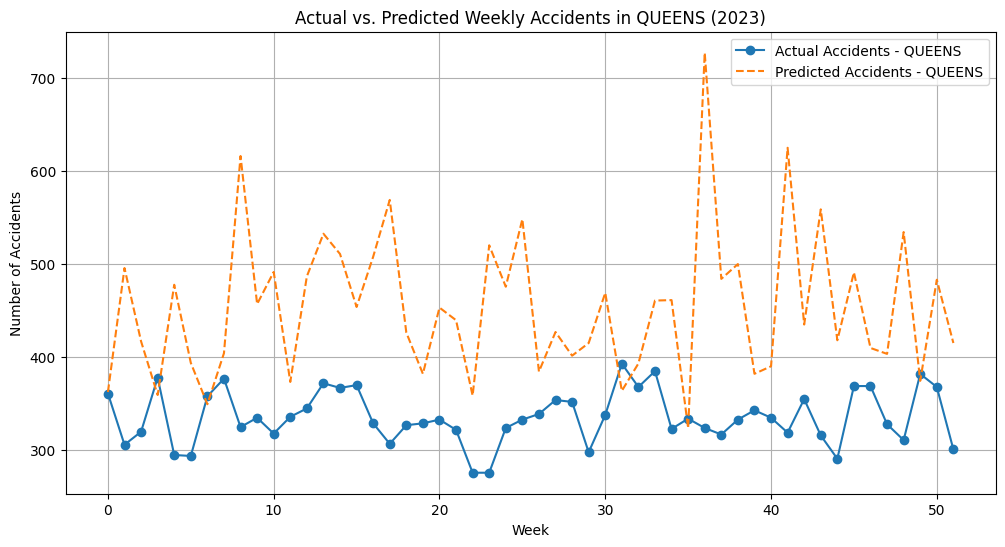

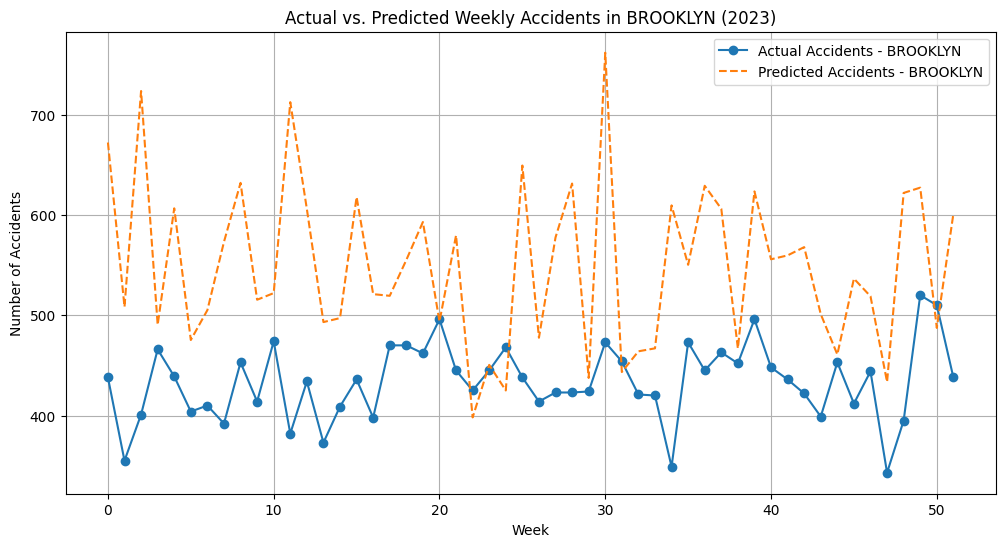

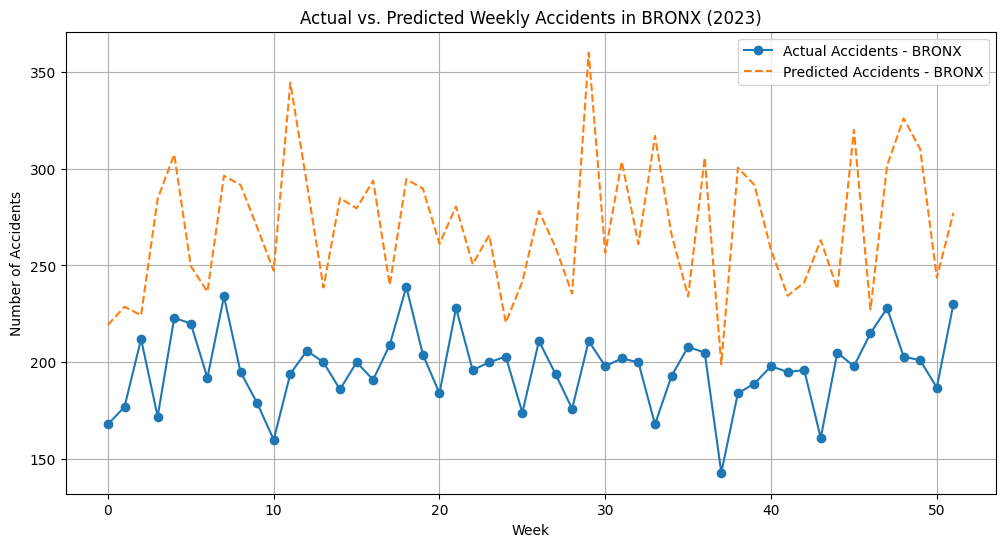

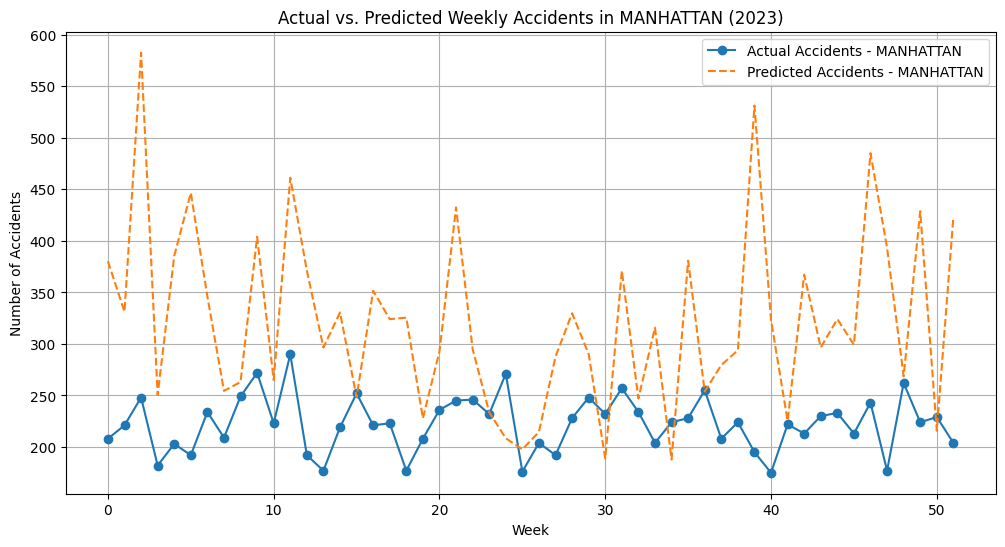

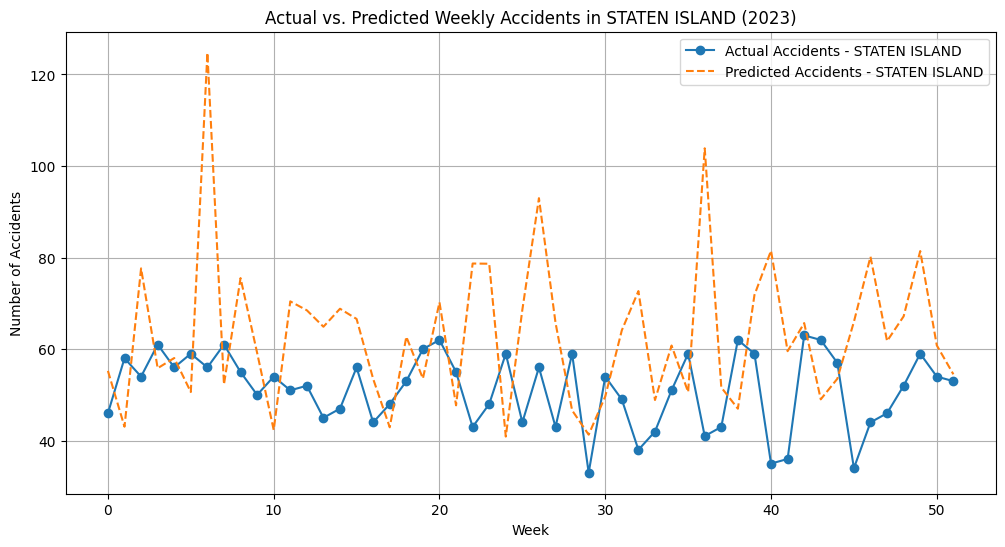

In [ ]:
# Plot actual vs. predicted values for each borough
for borough in boroughs:
    borough_name = borough["borough"]
    borough_test_data = test_data.filter(test_data.borough == borough_name)
    predictions = models[borough_name].transform(borough_test_data).select("label", "prediction").toPandas()

    # Plot actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(predictions.index, predictions["label"], label=f"Actual Accidents - {borough_name}", marker="o")
    plt.plot(predictions.index, predictions["prediction"], label=f"Predicted Accidents - {borough_name}", linestyle="--")
    plt.title(f"Actual vs. Predicted Weekly Accidents in {borough_name} (2023)")
    plt.xlabel("Week")
    plt.ylabel("Number of Accidents")
    plt.legend()
    plt.grid()
    plt.show()


####Linear Regression (Daily Forecasting)

In [ ]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, dayofyear, col, when, lit

# Add temporal features
daily_data = final_data_cat_encode.withColumn("year", year(col("crash date"))) \
    .withColumn("month", month(col("crash date"))) \
    .withColumn("day_of_week", dayofweek(col("crash date"))) \
    .withColumn("day_of_month", dayofmonth(col("crash date"))) \
    .withColumn("day_of_year", dayofyear(col("crash date")))


In [ ]:
# Assign weights
daily_data = daily_data.withColumn(
    "weight",
    when(daily_data.year == 2022, lit(1.8))
    .when(daily_data.year == 2021, lit(1.8))
    .when(daily_data.year == 2020, lit(1.0))
    .otherwise(lit(0.5))  # Lower weight for older years
)


In [ ]:
from pyspark.sql.functions import count

# Aggregate number of accidents per day and borough
daily_data = daily_data.groupBy("crash date", "borough").agg(
    count("collision_id").alias("num_accidents")
).join(daily_data, ["crash date", "borough"], "left")


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Define the feature columns for the model
feature_columns = [
    "latitude", "longitude", "temp", "feelslike", "dew", "humidity", "precipitation",
    "snow", "snowdepth", "windgust", "windspeed", "winddir", "visibility", "uvindex",
    "borough_index", "time_bucket_index", "zip_code_index", "conditions_index",
    "weather description_index", "year", "month", "day_of_week", "day_of_year"
]

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
daily_data_transformed = assembler.transform(daily_data).select(
    "features", "num_accidents", "borough", "weight", "year"
).withColumnRenamed("num_accidents", "label")


In [ ]:
# Unique boroughs
boroughs = daily_data_transformed.select("borough").distinct().collect()

# Loop through each borough
models = {}
for borough in boroughs:
    # Filter data for the borough
    borough_data = daily_data_transformed.filter(col("borough") == borough.borough)

    # Train-test split
    train_data = borough_data.filter(col("year") < 2023)
    test_data = borough_data.filter(col("year") == 2023)

    # Train model
    from pyspark.ml.regression import LinearRegression

    lr = LinearRegression(featuresCol="features", labelCol="label", weightCol="weight")
    lr_model = lr.fit(train_data)
    models[borough.borough] = lr_model

    # Test model
    predictions = lr_model.transform(test_data)
    predictions.select("features", "label", "prediction").show(5)


+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[40.744667,-73.93...|   66|33.948406834526395|
|[40.59872,-73.766...|   66| 34.42047994886525|
|[40.71032,-73.849...|   66| 36.73643928795718|
|[40.771587,-73.81...|   66| 37.36835479774527|
|[40.7518,-73.8173...|   66|36.278031794252456|
+--------------------+-----+------------------+
only showing top 5 rows

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[40.661983,-73.90...|   55|55.264217577001546|
|[40.711338,-73.92...|   55|54.411514088387776|
|[40.647324,-73.90...|   55| 54.03528960555559|
|[40.69473,-73.919...|   55| 55.43770155173479|
|[40.643143,-73.90...|   55| 55.32173547433922|
+--------------------+-----+------------------+
only showing top 5 rows

+--------------------+-----+------------------+
|            features|label|        pr

In [ ]:
from pyspark.sql.functions import avg, abs as abs_diff, sqrt

# Evaluate predictions
for borough, model in models.items():
    predictions = model.transform(test_data)

    predictions = predictions.withColumn("error", abs_diff(col("label") - col("prediction"))) \
        .withColumn("squared_error", (col("label") - col("prediction")) ** 2)

    # Compute MAE and RMSE
    mae = predictions.select(avg("error")).first()[0]
    rmse = predictions.select(sqrt(avg("squared_error"))).first()[0]

    print(f"Borough: {borough}, MAE: {mae}, RMSE: {rmse}")


Borough: QUEENS, MAE: 38.81927053892265, RMSE: 39.65610540200424
Borough: BROOKLYN, MAE: 54.01983879239784, RMSE: 54.69256107895052
Borough: BRONX, MAE: 2223.9675221568746, RMSE: 2223.973844518814
Borough: MANHATTAN, MAE: 13.892759237558437, RMSE: 15.586362630138737
Borough: STATEN ISLAND, MAE: 3.4802986098396587, RMSE: 4.318698628540558


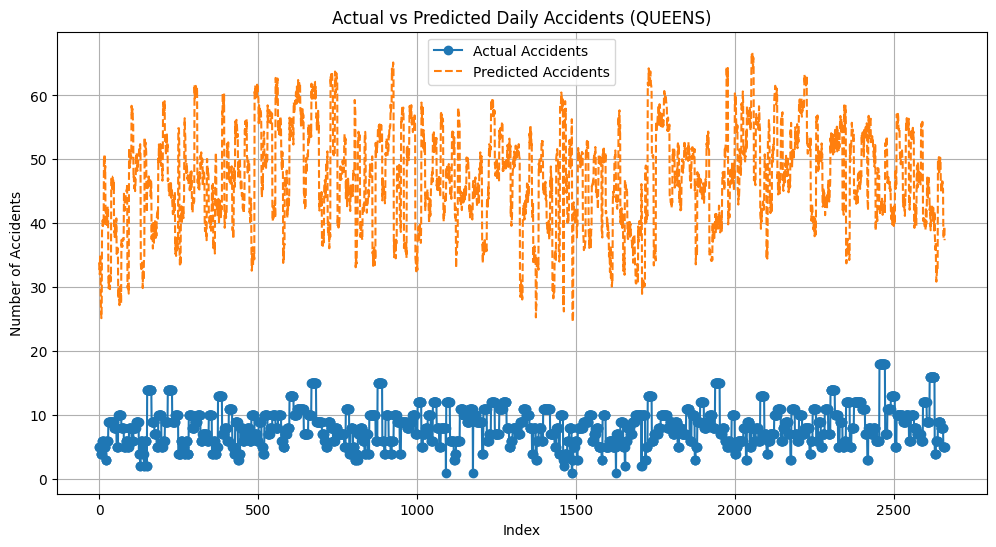

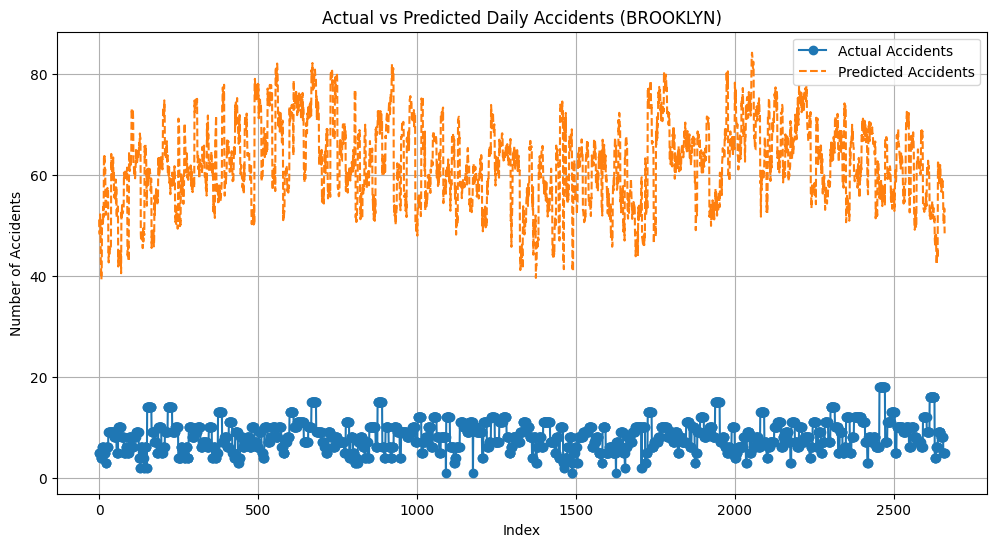

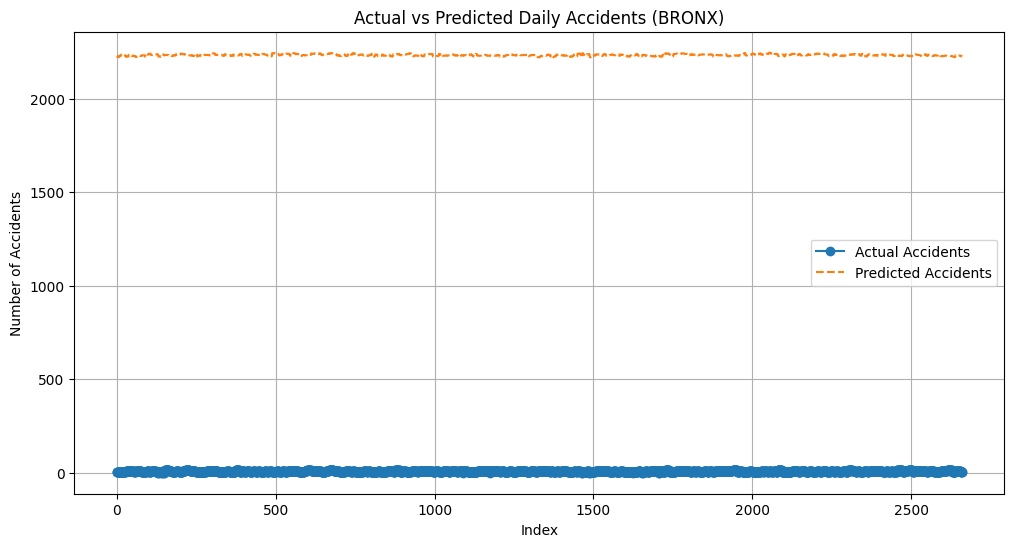

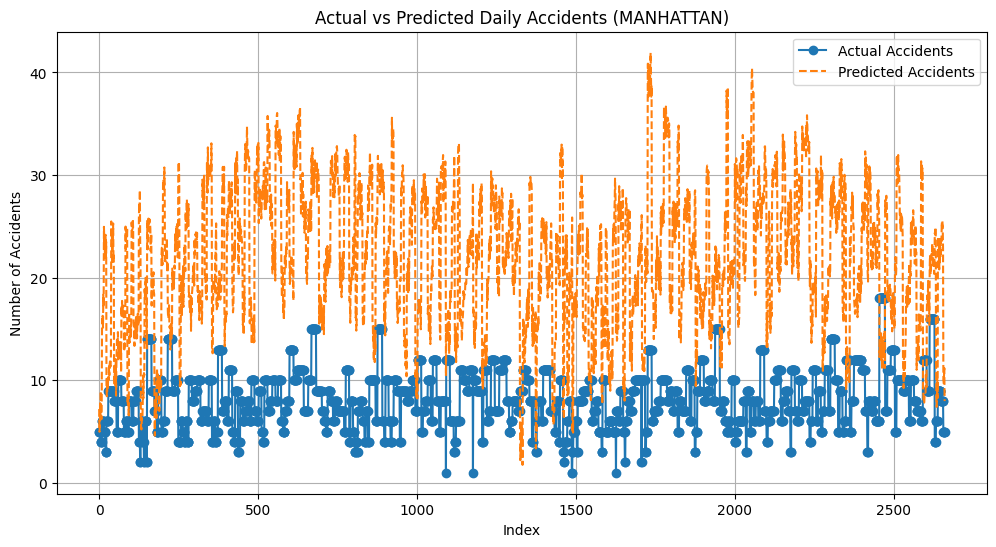

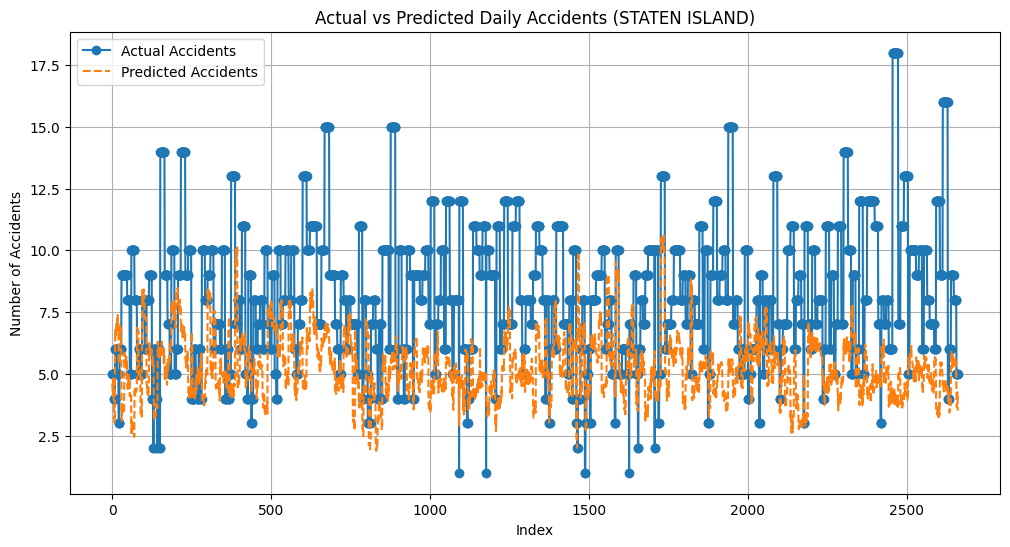

In [ ]:
import matplotlib.pyplot as plt

for borough, model in models.items():
    predictions = model.transform(test_data)
    comparison_df = predictions.select("label", "prediction").toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df["label"], label="Actual Accidents", marker="o")
    plt.plot(comparison_df.index, comparison_df["prediction"], label="Predicted Accidents", linestyle="--")
    plt.title(f"Actual vs Predicted Daily Accidents ({borough})")
    plt.xlabel("Index")
    plt.ylabel("Number of Accidents")
    plt.legend()
    plt.grid()
    plt.show()


####Random Forest (Weekly Forecasting)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, weekofyear, avg, count, when, lit, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt


In [ ]:
# Add temporal features and aggregate weekly data by borough
weekly_data = final_data_cat_encode.withColumn("crash_year", year(col("crash date"))) \
    .withColumn("crash_week", weekofyear(col("crash date"))) \
    .groupBy("borough", "crash_year", "crash_week") \
    .agg(
        count("collision_id").alias("num_accidents"),
        avg("temp").alias("avg_temp"),
        avg("humidity").alias("avg_humidity"),
        avg("precipitation").alias("avg_precipitation"),
        avg("windspeed").alias("avg_windspeed"),
        avg("conditions_index").alias("avg_conditions_index"),
        avg("weather description_index").alias("avg_weather_description_index")
    )

# Add weights based on crash_year
weekly_data = weekly_data.withColumn(
    "weight",
    when(weekly_data.crash_year == 2022, lit(1.8))
    .when(weekly_data.crash_year == 2021, lit(1.8))
    .when(weekly_data.crash_year == 2020, lit(1.0))
    .otherwise(lit(0.5))  # Lower weight for older years
)


In [ ]:
# Split the data into train and test sets
train_data = weekly_data.filter(weekly_data.crash_year < 2023)  # Train on pre-2023 data
test_data = weekly_data.filter(weekly_data.crash_year == 2023)  # Test on 2023 data


In [ ]:
# Define the feature columns for the model
feature_columns = [
    "avg_temp", "avg_humidity", "avg_precipitation",
    "avg_windspeed", "avg_conditions_index", "avg_weather_description_index"
]

# Assemble features for training and testing
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_data).select("borough", "features", "num_accidents", "weight") \
    .withColumnRenamed("num_accidents", "label")
test_data = assembler.transform(test_data).select("borough", "features", "num_accidents", "weight") \
    .withColumnRenamed("num_accidents", "label")


In [ ]:
# Train a Random Forest model for each borough with hyperparameter tuning
models = {}
boroughs = train_data.select("borough").distinct().collect()

for borough in boroughs:
    borough_name = borough["borough"]
    borough_train_data = train_data.filter(train_data.borough == borough_name)

    # Define Random Forest Regressor
    rf = RandomForestRegressor(featuresCol="features", labelCol="label", weightCol="weight")

    # Define ParamGrid for Hyperparameter Tuning
    param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20]) \
        .addGrid(rf.maxDepth, [5, 10]) \
        .build()

    # Define CrossValidator
    cross_val = CrossValidator(
        estimator=rf,
        estimatorParamMaps=param_grid,
        evaluator=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse"),
        numFolds=3
    )

    # Train the model
    models[borough_name] = cross_val.fit(borough_train_data)


In [ ]:
from pyspark.sql.functions import abs as F_abs, col, sqrt, avg

# Evaluate predictions for each borough
for borough in boroughs:
    borough_name = borough["borough"]
    borough_test_data = test_data.filter(col("borough") == borough_name)

    # Make predictions
    predictions = models[borough_name].transform(borough_test_data)

    # Calculate errors
    predictions = predictions.withColumn("error", F_abs(col("label") - col("prediction"))) \
                             .withColumn("squared_error", (col("label") - col("prediction")) ** 2)

    # Compute MAE and RMSE
    mae = predictions.select(avg("error").alias("mae")).first()["mae"]
    rmse = predictions.select(sqrt(avg("squared_error")).alias("rmse")).first()["rmse"]

    print(f"Borough: {borough_name}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")


Borough: QUEENS
Mean Absolute Error (MAE): 182.71114366413556
Root Mean Squared Error (RMSE): 205.646517046803
Borough: BROOKLYN
Mean Absolute Error (MAE): 190.0433065659309
Root Mean Squared Error (RMSE): 212.87007817980887
Borough: BRONX
Mean Absolute Error (MAE): 100.02478432647341
Root Mean Squared Error (RMSE): 108.00468694127935
Borough: MANHATTAN
Mean Absolute Error (MAE): 172.46362337572594
Root Mean Squared Error (RMSE): 194.7401090902213
Borough: STATEN ISLAND
Mean Absolute Error (MAE): 24.35467829350134
Root Mean Squared Error (RMSE): 30.410914067683905


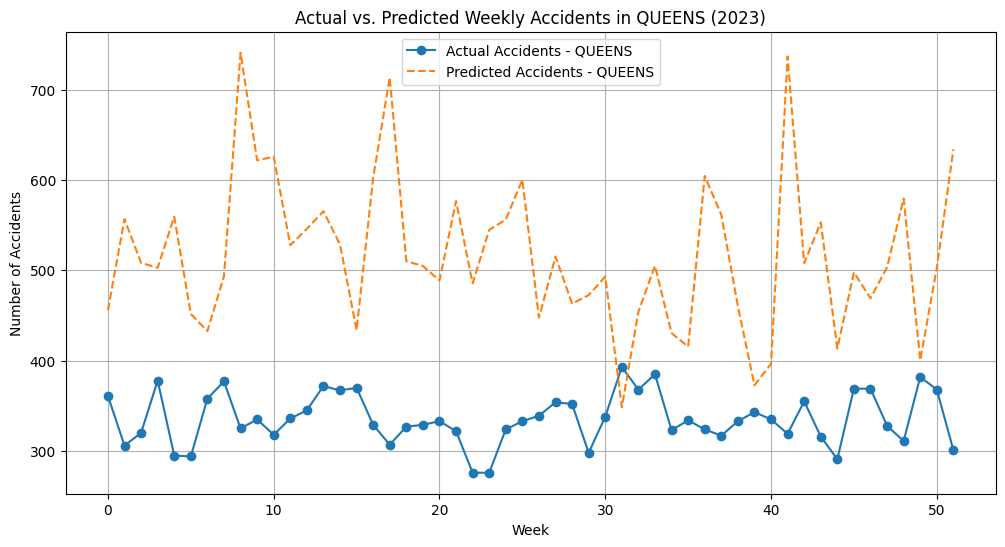

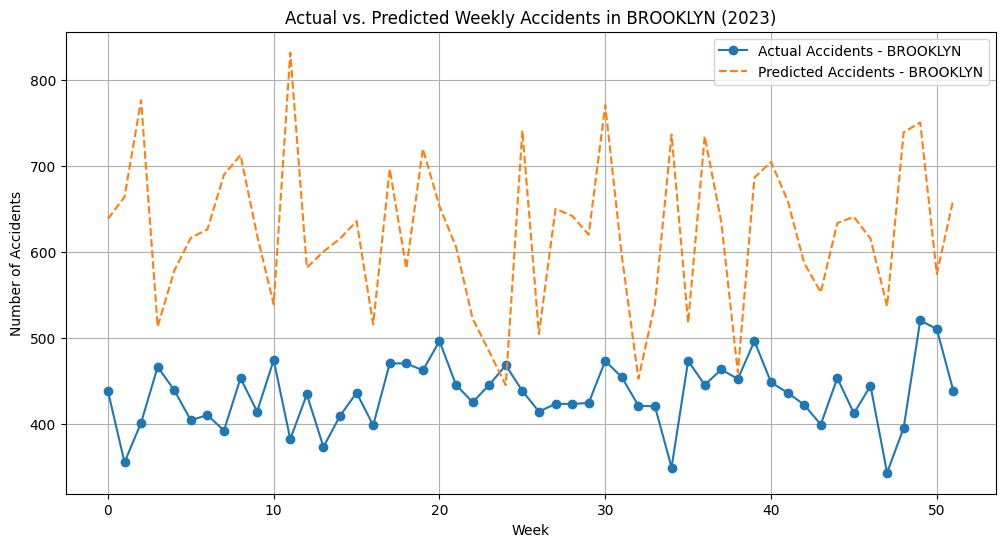

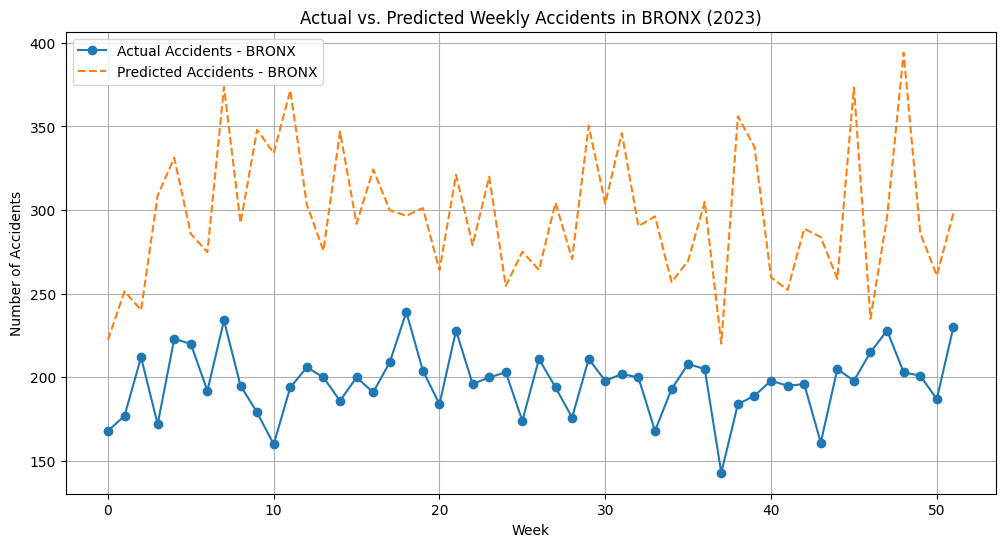

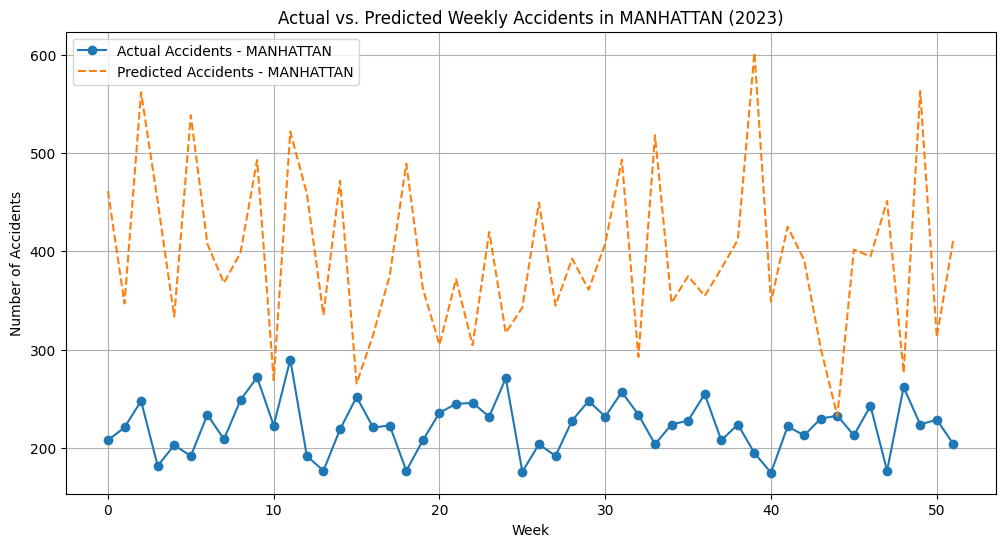

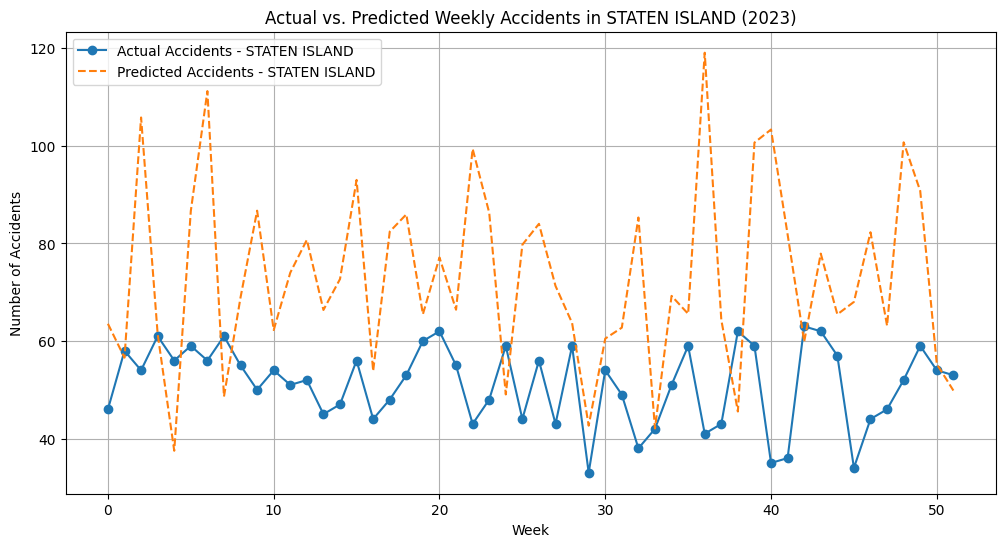

In [ ]:
# Plot actual vs. predicted values for each borough
for borough in boroughs:
    borough_name = borough["borough"]
    borough_test_data = test_data.filter(test_data.borough == borough_name)

    # Make predictions
    predictions = models[borough_name].transform(borough_test_data).select("label", "prediction").toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(predictions.index, predictions["label"], label=f"Actual Accidents - {borough_name}", marker="o")
    plt.plot(predictions.index, predictions["prediction"], label=f"Predicted Accidents - {borough_name}", linestyle="--")
    plt.title(f"Actual vs. Predicted Weekly Accidents in {borough_name} (2023)")
    plt.xlabel("Week")
    plt.ylabel("Number of Accidents")
    plt.legend()
    plt.grid()
    plt.show()


####Random Forest (Daily Forecasting)

In [ ]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, dayofyear, col, when, lit, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Add temporal features
daily_data = final_data_cat_encode.withColumn("year", year(col("crash date"))) \
    .withColumn("month", month(col("crash date"))) \
    .withColumn("day_of_week", dayofweek(col("crash date"))) \
    .withColumn("day_of_month", dayofmonth(col("crash date"))) \
    .withColumn("day_of_year", dayofyear(col("crash date")))

# Assign weights based on year
daily_data = daily_data.withColumn(
    "weight",
    when(daily_data.year == 2022, lit(1.8))
    .when(daily_data.year == 2021, lit(1.8))
    .when(daily_data.year == 2020, lit(1.0))
    .otherwise(lit(0.5))  # Lower weight for older years
)


In [ ]:
# Group the data by 'crash date' and 'borough' to calculate the number of accidents
# Count the number of collisions and alias as 'num_accidents'
# Join the aggregated data back with the original dataset to retain additional columns

daily_data = daily_data.groupBy("crash date", "borough").agg(
    count("collision_id").alias("num_accidents")
).join(daily_data, ["crash date", "borough"], "left")


In [ ]:
# Define the list of features to be used for the machine learning model
feature_columns = [
    "latitude", "longitude", "temp", "feelslike", "dew", "humidity",
    "precipitation", "snow", "snowdepth", "windgust", "windspeed", "winddir",
    "visibility", "uvindex", "borough_index", "time_bucket_index",
    "zip_code_index", "conditions_index", "weather description_index",
    "year", "month", "day_of_week", "day_of_month", "day_of_year"
]

# Use VectorAssembler to combine all feature columns into a single vector for ML models
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the original data to include the feature vector and prepare it for modeling
daily_data_transformed = assembler.transform(daily_data).select(
    "features", "num_accidents", "borough", "weight", "year"
).withColumnRenamed("num_accidents", "label")


In [ ]:

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import abs as F_abs, col, avg, sqrt

# Initialize a dictionary to store models for each borough
models = {}

# Select unique boroughs from the dataset
boroughs = daily_data_transformed.select("borough").distinct().collect()

# Iterate through each borough for training and testing
for borough_row in boroughs:
    borough_name = borough_row["borough"]
    borough_data = daily_data_transformed.filter(col("borough") == borough_name)

    # Train-test split
    train_data = borough_data.filter(col("year") < 2023)
    test_data = borough_data.filter(col("year") == 2023)

    # Define the Random Forest Regressor
    rf = RandomForestRegressor(featuresCol="features", labelCol="label", weightCol="weight")

    # Define hyperparameter grid
    param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20]) \
        .addGrid(rf.maxDepth, [5, 10]) \
        .build()

    # Define evaluator
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

    # Define TrainValidationSplit
    train_val_split = TrainValidationSplit(
        estimator=rf,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        trainRatio=0.8
    )

    # Train the model
    rf_model = train_val_split.fit(train_data)
    models[borough_name] = rf_model.bestModel

    # Predict on test data
    predictions = rf_model.bestModel.transform(test_data)

    # Calculate errors
    predictions = predictions.withColumn("error", F_abs(col("label") - col("prediction"))) \
                             .withColumn("squared_error", (col("label") - col("prediction")) ** 2)

    # Compute MAE and RMSE
    mae = predictions.select(avg("error").alias("mae")).first()["mae"]
    rmse = predictions.select(sqrt(avg("squared_error")).alias("rmse")).first()["rmse"]

    # Print evaluation metrics
    print(f"Borough: {borough_name}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")


Borough: QUEENS
Mean Absolute Error (MAE): 6.833225048744261
Root Mean Squared Error (RMSE): 8.639174964017268
Borough: BROOKLYN
Mean Absolute Error (MAE): 8.670714119458745
Root Mean Squared Error (RMSE): 10.767845635395126
Borough: BRONX
Mean Absolute Error (MAE): 7.301244319881379
Root Mean Squared Error (RMSE): 8.784124849866792
Borough: MANHATTAN
Mean Absolute Error (MAE): 5.812610229260611
Root Mean Squared Error (RMSE): 7.22058191811525
Borough: STATEN ISLAND
Mean Absolute Error (MAE): 2.235297115101442
Root Mean Squared Error (RMSE): 2.878518752352707


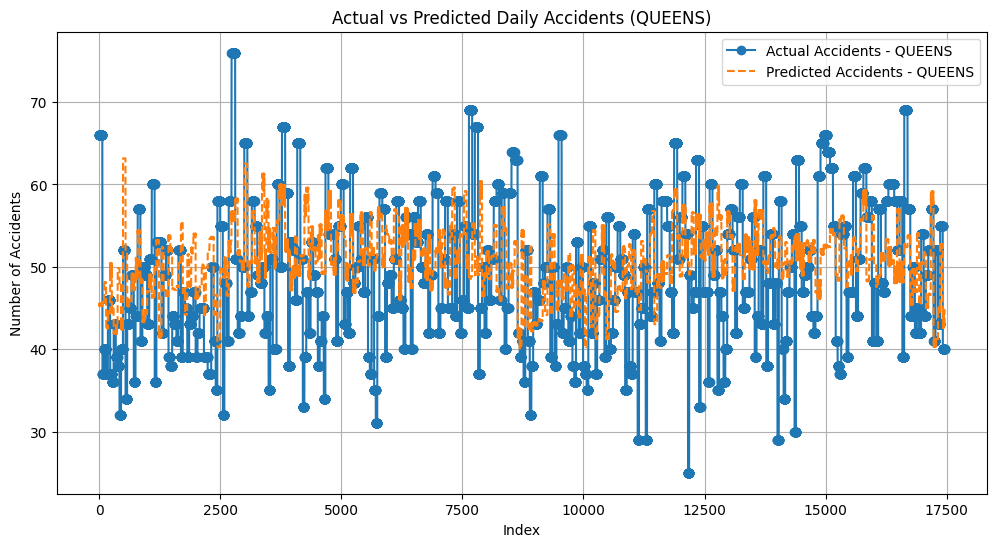

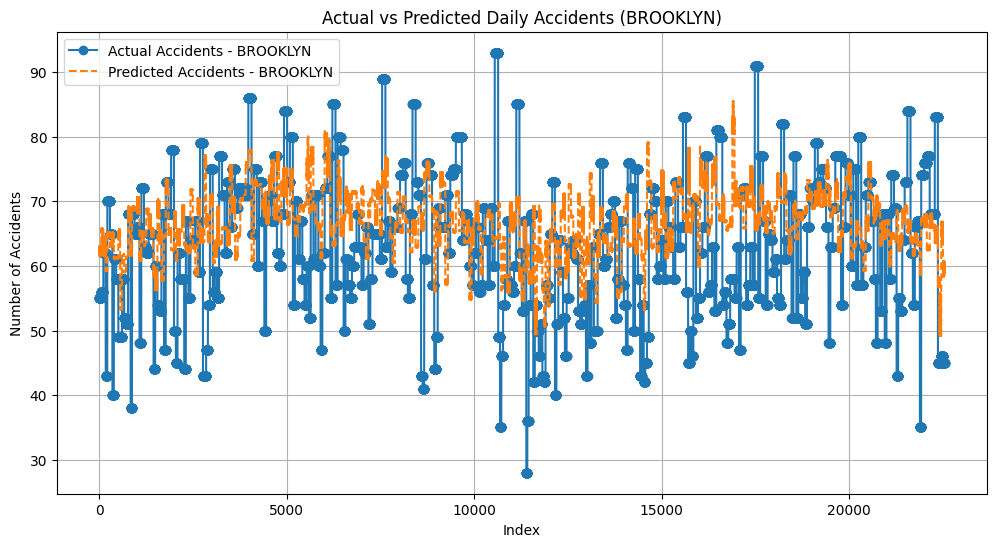

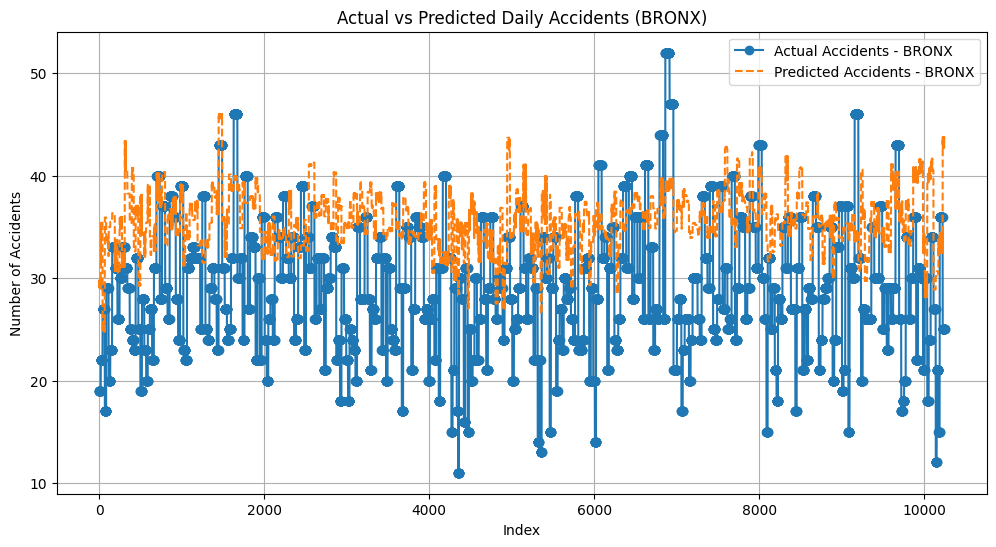

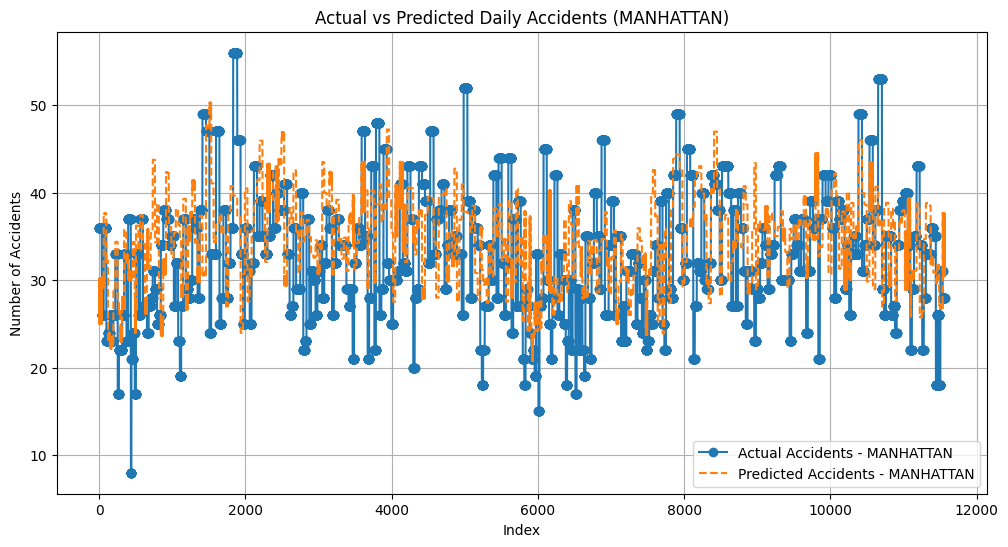

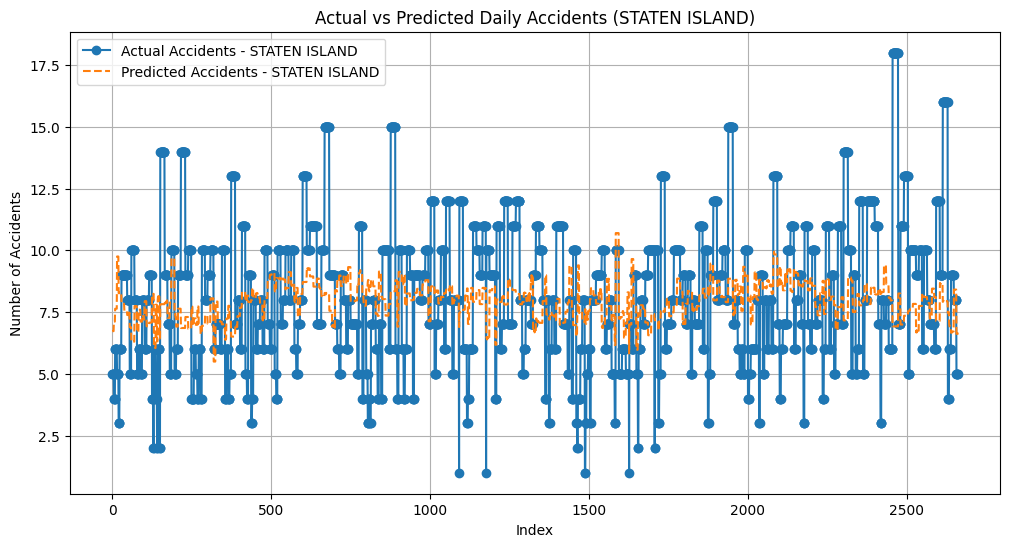

In [ ]:
for borough_row in boroughs:
    borough_name = borough_row["borough"]
    borough_data = daily_data_transformed.filter(col("borough") == borough_name)
    test_data = borough_data.filter(col("year") == 2023)

    predictions = models[borough_name].transform(test_data)
    comparison_df = predictions.select("label", "prediction").toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df["label"], label=f"Actual Accidents - {borough_name}", marker="o")
    plt.plot(comparison_df.index, comparison_df["prediction"], label=f"Predicted Accidents - {borough_name}", linestyle="--")
    plt.title(f"Actual vs Predicted Daily Accidents ({borough_name})")
    plt.xlabel("Index")
    plt.ylabel("Number of Accidents")
    plt.legend()
    plt.grid()
    plt.show()


####GBT

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Load CSV").getOrCreate()

# Load the CSV file into a PySpark DataFrame
final_data_cat_encode = spark.read.csv("/content/final_data_cat_encode.csv", header=True, inferSchema=True)

# Verify the schema and data
final_data_cat_encode.printSchema()
final_data_cat_encode.show(5)

# Get the number of rows
row_count = final_data_cat_encode.count()

# Get the number of columns
column_count = len(final_data_cat_encode.columns)

# Print the results
print(f"Number of Rows: {row_count}")
print(f"Number of Columns: {column_count}")


root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)
 |-- time_bucket: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer 

In [ ]:
from pyspark.sql.functions import year, month, dayofweek, dayofmonth, dayofyear
from pyspark.sql.functions import abs as F_abs, col, avg, sqrt

daily_data = final_data_cat_encode.withColumn("year", year(col("crash date"))) \
    .withColumn("month", month(col("crash date"))) \
    .withColumn("day_of_week", dayofweek(col("crash date"))) \
    .withColumn("day_of_month", dayofmonth(col("crash date"))) \
    .withColumn("day_of_year", dayofyear(col("crash date")))


In [ ]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, dayofyear, col, when, lit, count

daily_data = daily_data.withColumn(
    "season",
    when((col("month") >= 3) & (col("month") <= 5), "Spring")
    .when((col("month") >= 6) & (col("month") <= 8), "Summer")
    .when((col("month") >= 9) & (col("month") <= 11), "Autumn")
    .otherwise("Winter")
)


In [ ]:
daily_data = daily_data.withColumn(
    "weight",
    when(col("year") == 2022, lit(2.0))  # Highest weight for 2022
    .when(col("year") == 2021, lit(2.0))  # Highest weight for 2021
    .when(col("year").between(2019, 2020), lit(1.5))  # Moderate weight for 2019-2020
    .when(col("year") < 2019, lit(1.0))  # Lowest weight for years before 2019
    .otherwise(lit(0.5))  # Lower weight for testing years
)


In [ ]:
daily_data = daily_data.groupBy("crash date", "borough").agg(
    count("collision_id").alias("num_accidents")
).join(daily_data, ["crash date", "borough"], "left")


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

window_spec = Window.partitionBy("borough").orderBy("crash date")
daily_data = daily_data.withColumn("lagged_accidents", lag("num_accidents", 1).over(window_spec))
daily_data = daily_data.fillna({"lagged_accidents": 0})


In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, expr
from pyspark.ml.functions import vector_to_array

# Define numeric features to be scaled
numeric_features = [
    "temp", "feelslike", "dew", "humidity", "precipitation", "snow",
    "snowdepth", "windgust", "windspeed", "winddir", "visibility",
    "uvindex", "lagged_accidents"
]

# Assemble numeric features into a single vector
assembler = VectorAssembler(inputCols=numeric_features, outputCol="unscaled_features")

# Apply MinMaxScaler to scale the features
scaler = MinMaxScaler(inputCol="unscaled_features", outputCol="scaled_features")

# Create a pipeline for scaling
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the data
scaled_data = pipeline.fit(daily_data).transform(daily_data)

# Convert vector to array to access individual elements
scaled_data = scaled_data.withColumn("scaled_features_array", vector_to_array(col("scaled_features")))

# Extract scaled features into separate columns
for i, feature in enumerate(numeric_features):
    scaled_data = scaled_data.withColumn(f"scaled_{feature}", col("scaled_features_array")[i])

# Drop unnecessary columns
scaled_data = scaled_data.drop("unscaled_features", "scaled_features", "scaled_features_array")

# Show the resulting schema and a sample of the scaled data
scaled_data.printSchema()
scaled_data.show(5)


root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- num_accidents: long (nullable = false)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)
 |-- time_bucket: string (nullable = true)
 |-- year: in

In [ ]:
# Define the list of features to be used for the model
feature_columns = [
    "scaled_temp", "scaled_feelslike", "scaled_dew", "scaled_humidity",
    "scaled_precipitation", "scaled_snow", "scaled_snowdepth", "scaled_windgust",
    "scaled_windspeed", "scaled_winddir", "scaled_visibility", "scaled_uvindex",
    "scaled_lagged_accidents", "day_of_week", "day_of_month", "day_of_year"
]

# Use VectorAssembler to combine all feature columns into a single vector for ML models
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

#  Transform the original data to include the feature vector and prepare it for modeling
daily_data_transformed = assembler.transform(scaled_data).select(
    "features", "num_accidents", "borough", "weight", "year"
).withColumnRenamed("num_accidents", "label")


Borough: QUEENS
Root Mean Squared Error (RMSE): 7.878077936715781
R-squared Value (R2): 0.1572296057522552
Mean Absolute Error (MAE): 4.56297095735465


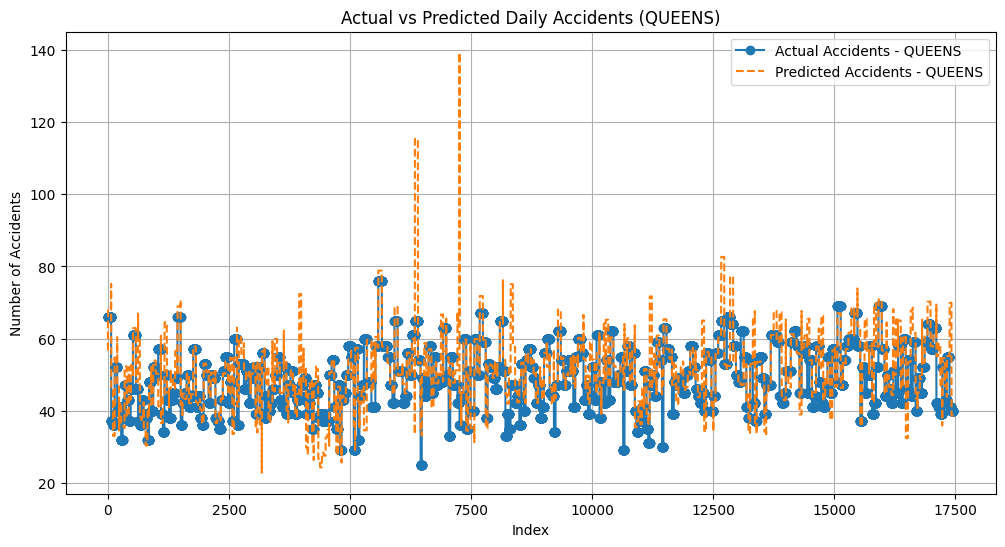

Borough: BROOKLYN
Root Mean Squared Error (RMSE): 10.552530759905181
R-squared Value (R2): 0.026062906947138975
Mean Absolute Error (MAE): 5.089850830580534


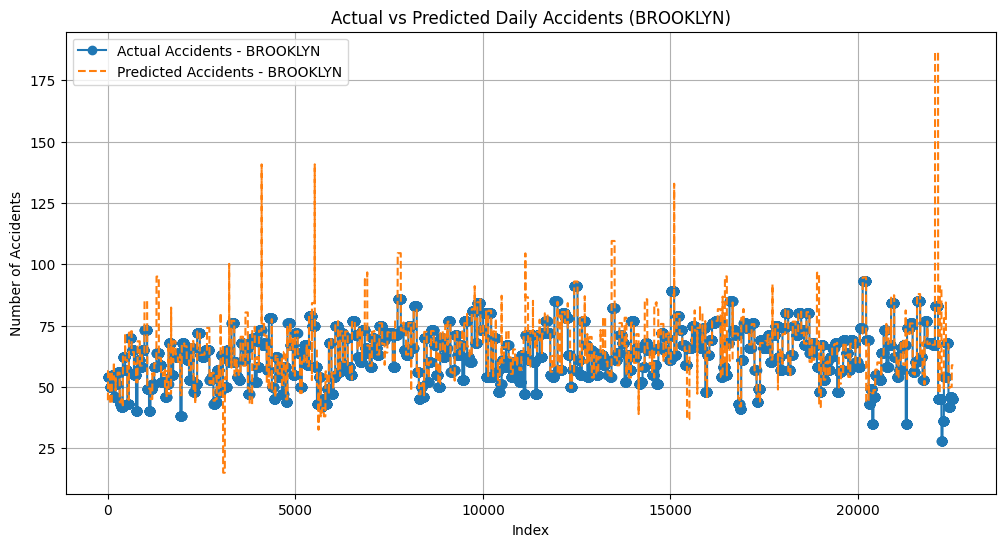

Borough: BRONX
Root Mean Squared Error (RMSE): 9.186709630698633
R-squared Value (R2): -1.0036820920655418
Mean Absolute Error (MAE): 5.140302963919384


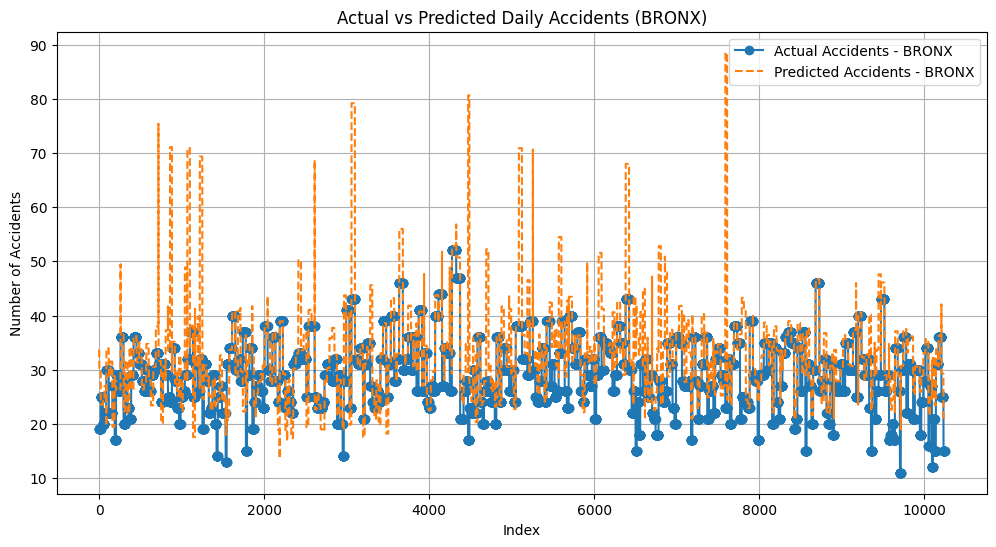

Borough: MANHATTAN
Root Mean Squared Error (RMSE): 6.84558571564824
R-squared Value (R2): 0.10637562685548152
Mean Absolute Error (MAE): 3.4939337650529416


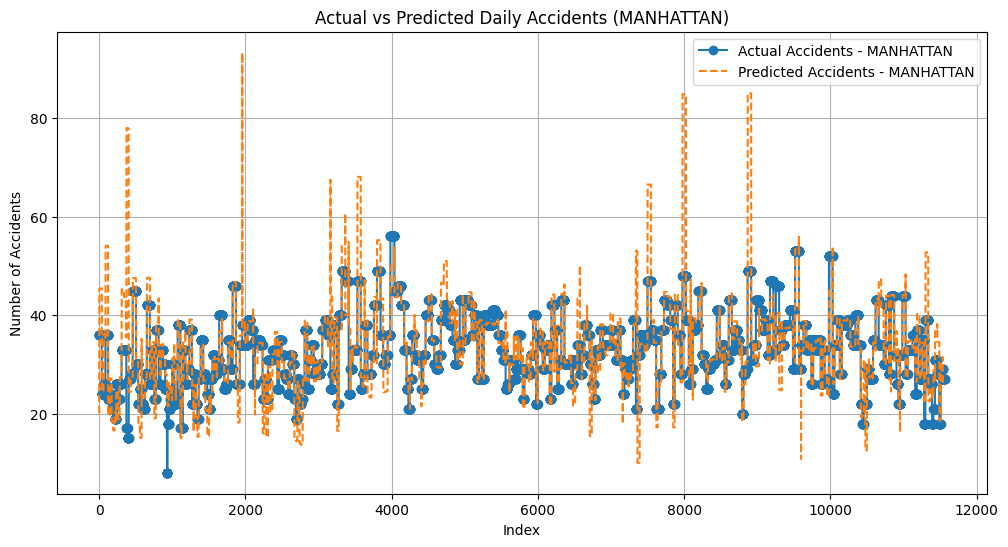

Borough: STATEN ISLAND
Root Mean Squared Error (RMSE): 1.484544184792329
R-squared Value (R2): 0.7158296036515279
Mean Absolute Error (MAE): 0.6006356753150154


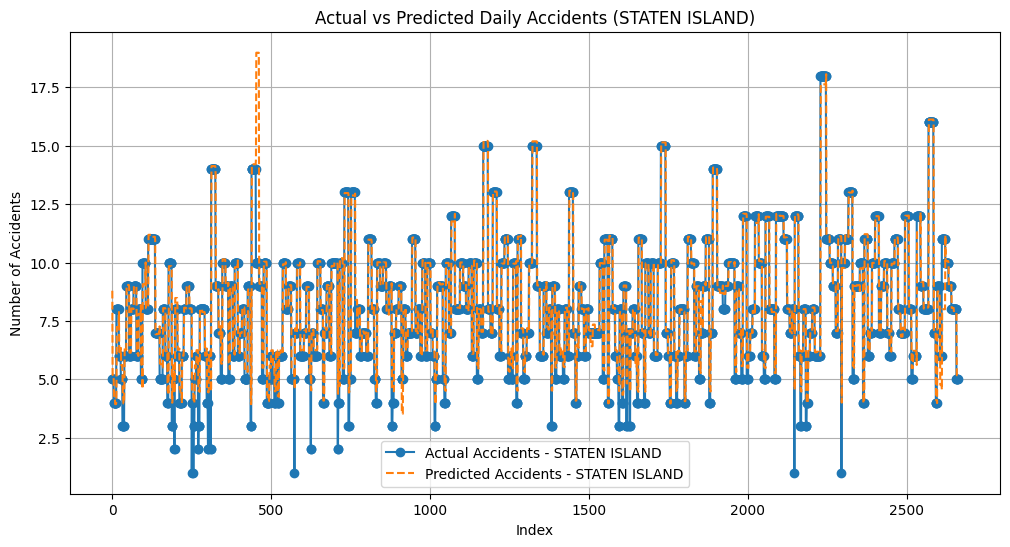

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

models_gbt = {}
boroughs = daily_data_transformed.select("borough").distinct().collect()

for borough_row in boroughs:
    borough_name = borough_row["borough"]
    borough_data = daily_data_transformed.filter(col("borough") == borough_name)

    # Train/test split
    train_data = borough_data.filter(col("year") < 2023)
    test_data = borough_data.filter(col("year") == 2023)

    # Define GBT model
    gbt = GBTRegressor(featuresCol="features", labelCol="label", weightCol="weight", maxIter=20)

    # Hyperparameter tuning
    param_grid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5, 10]) \
        .addGrid(gbt.maxIter, [10, 20]) \
        .build()

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    train_val_split = TrainValidationSplit(
        estimator=gbt,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        trainRatio=0.8
    )

    # Train the model
    gbt_model = train_val_split.fit(train_data)
    models_gbt[borough_name] = gbt_model.bestModel

    # Test the model
    predictions = gbt_model.bestModel.transform(test_data)

    # Calculate metrics
    predictions = predictions.withColumn("error", F_abs(col("label") - col("prediction"))) \
                             .withColumn("squared_error", (col("label") - col("prediction")) ** 2)

    mae = predictions.select(avg("error").alias("mae")).first()["mae"]
    rmse = predictions.select(sqrt(avg("squared_error")).alias("rmse")).first()["rmse"]

    # Calculate R-squared
    r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)

    print(f"Borough: {borough_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared Value (R2): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Visualization
    comparison_df = predictions.select("label", "prediction").toPandas()
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df["label"], label=f"Actual Accidents - {borough_name}", marker="o")
    plt.plot(comparison_df.index, comparison_df["prediction"], label=f"Predicted Accidents - {borough_name}", linestyle="--")
    plt.title(f"Actual vs Predicted Daily Accidents ({borough_name})")
    plt.xlabel("Index")
    plt.ylabel("Number of Accidents")
    plt.legend()
    plt.grid()
    plt.show()


####GBT LOG Transformed

In [ ]:
from pyspark.sql.functions import col, log1p

# Define a list of numeric features to transform using log scaling
numeric_features = [
    "temp", "feelslike", "dew", "humidity", "precipitation", "snow",
    "snowdepth", "windgust", "windspeed", "winddir", "visibility", "uvindex"
]

# Apply log transformation to each numeric feature for better data scaling and reducing skewness
for feature in numeric_features:
    final_data_cat_encode = final_data_cat_encode.withColumn(f"log_{feature}", log1p(col(feature)))


In [ ]:
# Aggregate the number of accidents (daily) by 'crash date' and 'borough'
aggregated_data = final_data_cat_encode.groupBy("crash date", "borough").agg(
    count("collision_id").alias("daily_num_accidents")
)

# Join aggregated data with the original dataset
daily_data = aggregated_data.join(final_data_cat_encode, ["crash date", "borough"], "left")


In [ ]:
# Define a window specification to calculate lagged values of daily accidents
window_spec = Window.partitionBy("borough").orderBy("crash date")

# Add a new column with the number of accidents from the previous day (lagging by 1)
daily_data = daily_data.withColumn(
    "lagged_accidents", lag("daily_num_accidents", 1).over(window_spec)
)

# Fill missing values in the 'lagged_accidents' column with 0 (e.g., for the first day of each borough)
daily_data = daily_data.fillna({"lagged_accidents": 0})


In [ ]:
# Assign weights to rows based on the year for modeling purposes
daily_data = daily_data.withColumn(
    "weight",
    when(col("year") == 2022, lit(2.0)) \
    .when(col("year") == 2021, lit(2.0)) \
    .when(col("year").between(2019, 2020), lit(1.5)) \
    .when(col("year") < 2019, lit(1.0)) \
    .otherwise(lit(0.5))
)


In [ ]:
feature_columns = [
    f"log_{feature}" for feature in numeric_features
] + ["lagged_accidents"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform data to include features
daily_data_transformed = assembler.transform(daily_data).select(
    "features", "daily_num_accidents", "borough", "year", "weight"
).withColumnRenamed("daily_num_accidents", "label")


Training model for borough: QUEENS
Borough: QUEENS
Root Mean Squared Error (RMSE): 8.238273597331126
R-squared Value (R2): 0.07840279910366288
Mean Absolute Error (MAE): 4.1290015063606385


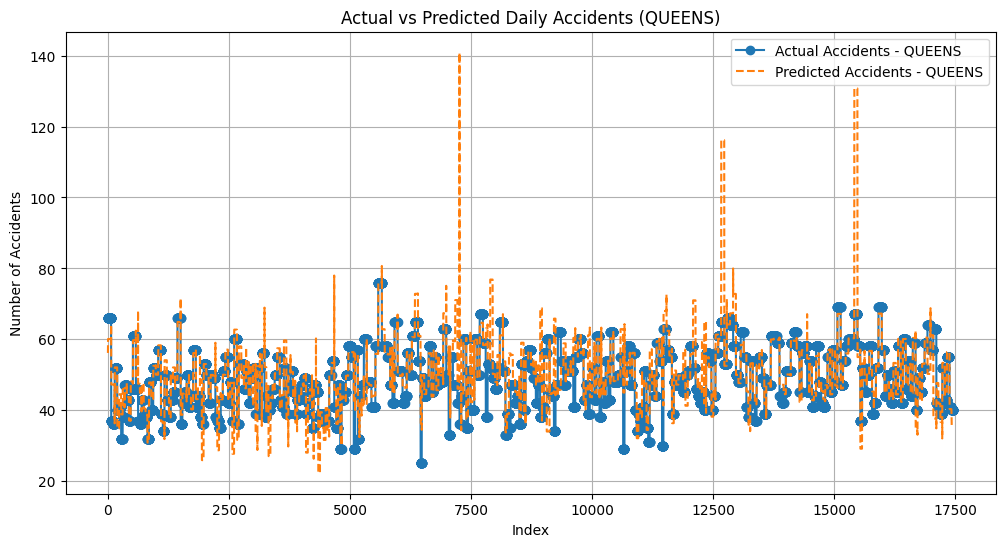

Training model for borough: BROOKLYN
Borough: BROOKLYN
Root Mean Squared Error (RMSE): 9.855113181338437
R-squared Value (R2): 0.15054400513798893
Mean Absolute Error (MAE): 5.301596879751672


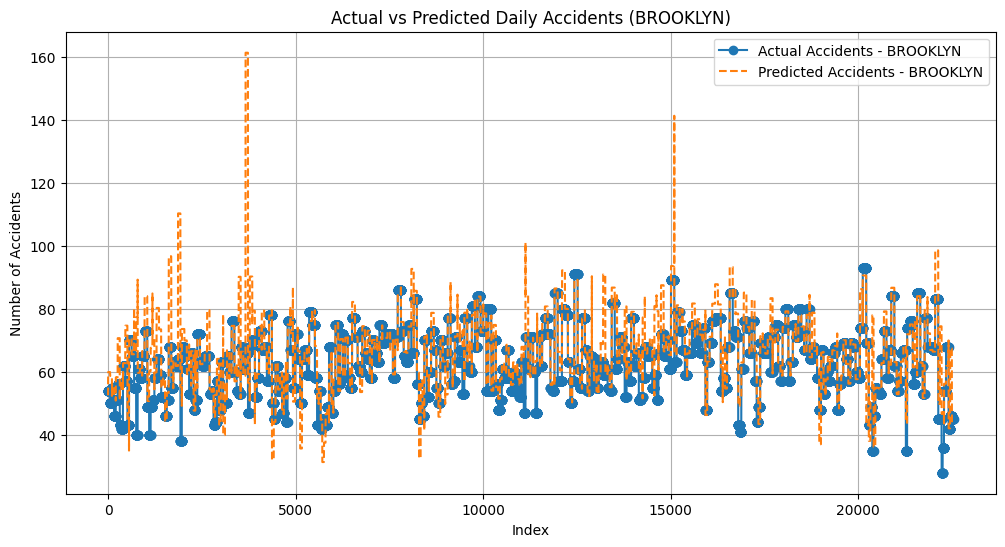

Training model for borough: BRONX
Borough: BRONX
Root Mean Squared Error (RMSE): 8.524713007257382
R-squared Value (R2): -0.7253148938432252
Mean Absolute Error (MAE): 4.99471854081348


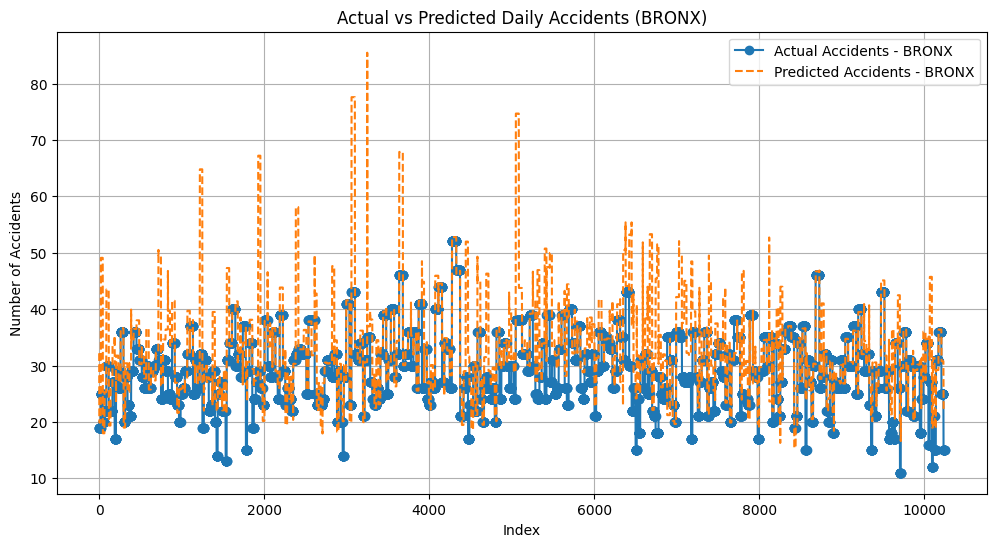

Training model for borough: MANHATTAN
Borough: MANHATTAN
Root Mean Squared Error (RMSE): 6.307646084611163
R-squared Value (R2): 0.2413029158484844
Mean Absolute Error (MAE): 3.37660995375346


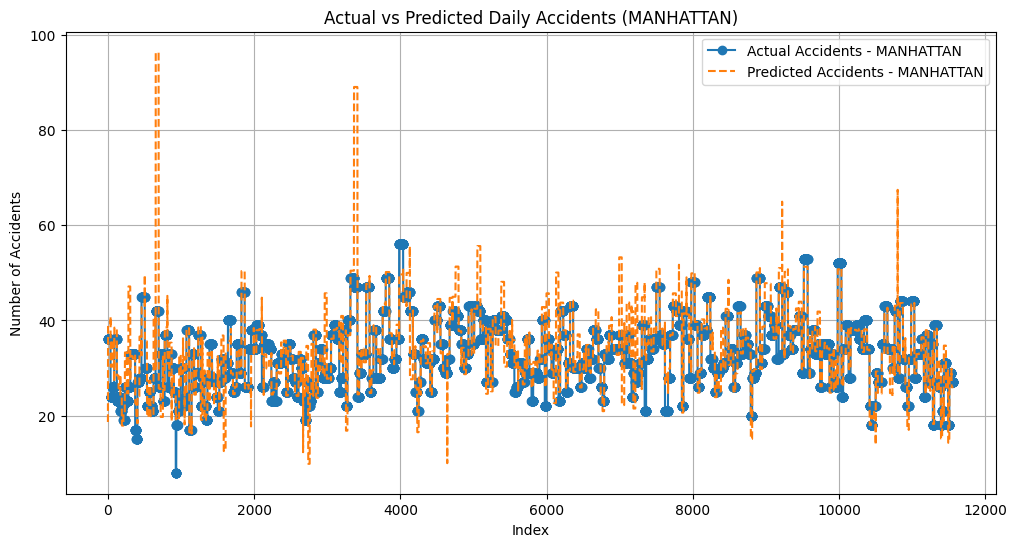

Training model for borough: STATEN ISLAND
Borough: STATEN ISLAND
Root Mean Squared Error (RMSE): 2.5858478331241717
R-squared Value (R2): 0.13781888418340882
Mean Absolute Error (MAE): 1.3668975254022975


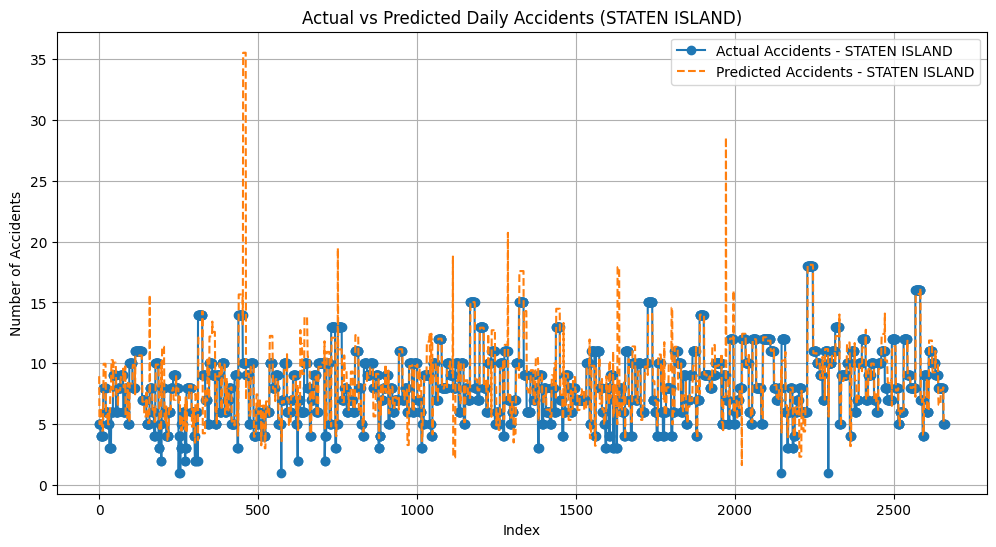

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

models_gbt = {}
boroughs = daily_data_transformed.select("borough").distinct().collect()

for borough_row in boroughs:
    borough_name = borough_row["borough"]
    print(f"Training model for borough: {borough_name}")

    borough_data = daily_data_transformed.filter(col("borough") == borough_name)

    # Train-test split
    train_data = borough_data.filter(col("year") < 2023)
    test_data = borough_data.filter(col("year") == 2023)

    # Define GBT model
    gbt = GBTRegressor(featuresCol="features", labelCol="label", weightCol="weight", maxIter=20)

    # Hyperparameter tuning
    param_grid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5, 10]) \
        .addGrid(gbt.maxIter, [10, 20]) \
        .build()

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    train_val_split = TrainValidationSplit(
        estimator=gbt,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        trainRatio=0.8
    )

    # Train model
    gbt_model = train_val_split.fit(train_data)
    models_gbt[borough_name] = gbt_model.bestModel

    # Test model
    predictions = gbt_model.bestModel.transform(test_data)

    # Calculate metrics
    mae = predictions.selectExpr("avg(abs(label - prediction)) as mae").first()["mae"]
    rmse = evaluator.evaluate(predictions)
    r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)

    print(f"Borough: {borough_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared Value (R2): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Visualization
    comparison_df = predictions.select("label", "prediction").toPandas()
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df["label"], label=f"Actual Accidents - {borough_name}", marker="o")
    plt.plot(comparison_df.index, comparison_df["prediction"], label=f"Predicted Accidents - {borough_name}", linestyle="--")
    plt.title(f"Actual vs Predicted Daily Accidents ({borough_name})")
    plt.xlabel("Index")
    plt.ylabel("Number of Accidents")
    plt.legend()
    plt.grid()
    plt.show()


####Naive Bayes

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes

# Initialize Spark session
spark = SparkSession.builder.appName("Borough-wise Naive Bayes").getOrCreate()


In [ ]:
# Load the scaled dataset
final_data = spark.read.csv("/content/scaled_final_data.csv", header=True, inferSchema=True)

# Verify the schema and basic details
final_data.printSchema()
final_data.show(5)
print(f"Number of Rows: {final_data.count()}")
print(f"Number of Columns: {len(final_data.columns)}")


root
 |-- crash date: date (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- collision_id: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather description: string (nullable = true)
 |-- time_bucket: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer 

In [ ]:
# Calculate the number of accidents per day and borough
daily_accidents = final_data.groupBy("crash date", "borough").agg(
    count("collision_id").alias("num_accidents")
)

# Join the calculated `num_accidents` back to the original data
final_data_with_accidents = final_data.join(
    daily_accidents, ["crash date", "borough"], "left"
)

# Verify the updated data
final_data_with_accidents.show(5)


+----------+-------------+--------+----------+-----------+------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------------+--------------------+-----------+----+-----+-----------+-------------+-----------------+-------------+---------------+--------------+----------------+-------------------------+------------------+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-----------+----------------+-------------------+------------------+------------------+-----------------+--------------+-------------+
|crash date|      borough|zip_code|  latitude|  longitude|collision_id|temp|feelslike| dew|humidity|precipitation|snow|snowdepth|windgust|windspeed|winddir|visibility|uvindex|            sunrise|             sunset|      conditions| weather description|time_bucket|year|month|day_of_week|borough_index|time_bucket_inde

In [ ]:
# Add a binary label column: 1 for "high accident" (days with >20 accidents), 0 for "low accident"
classification_data = final_data_with_accidents.withColumn(
    "label", when(col("num_accidents") > 20, 1).otherwise(0)
)

# Verify the updated dataset
classification_data.show(5)


+----------+-------------+--------+----------+-----------+------------+----+---------+----+--------+-------------+----+---------+--------+---------+-------+----------+-------+-------------------+-------------------+----------------+--------------------+-----------+----+-----+-----------+-------------+-----------------+-------------+---------------+--------------+----------------+-------------------------+------------------+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-----------+----------------+-------------------+------------------+------------------+-----------------+--------------+-------------+-----+
|crash date|      borough|zip_code|  latitude|  longitude|collision_id|temp|feelslike| dew|humidity|precipitation|snow|snowdepth|windgust|windspeed|winddir|visibility|uvindex|            sunrise|             sunset|      conditions| weather description|time_bucket|year|month|day_of_week|borough_index|time_bucke

In [ ]:
# Select numeric columns for features
feature_columns = [
    "latitude_scaled", "longitude_scaled", "temp_scaled", "feelslike_scaled",
    "dew_scaled", "humidity_scaled", "precipitation_scaled", "snow_scaled",
    "snowdepth_scaled", "windgust_scaled", "windspeed_scaled", "winddir_scaled",
    "visibility_scaled", "uvindex_scaled", "year", "month", "day_of_week"
]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(classification_data).select("features", "label", "borough")


In [ ]:
# Get the unique list of boroughs
boroughs = data_with_features.select("borough").distinct().collect()

# Dictionary to store trained models
models = {}

for borough_row in boroughs:
    borough_name = borough_row["borough"]
    print(f"Training model for borough: {borough_name}")

    # Filter data for the current borough
    borough_data = data_with_features.filter(col("borough") == borough_name)

    # Split data into training and testing sets
    train_data, test_data = borough_data.randomSplit([0.8, 0.2], seed=42)

    # Initialize and train the Naive Bayes model
    nb = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction", modelType="multinomial")
    nb_model = nb.fit(train_data)
    models[borough_name] = nb_model

    # Evaluate the model on the test data
    predictions = nb_model.transform(test_data)
    predictions.show(5)

    # Calculate accuracy
    total = predictions.count()
    correct = predictions.filter(predictions.label == predictions.prediction).count()
    accuracy = correct / total if total > 0 else 0
    print(f"Borough: {borough_name}")
    print(f"Accuracy: {accuracy:.2%}")


Training model for borough: QUEENS
+--------------------+-----+-------+--------------------+--------------------+----------+
|            features|label|borough|       rawPrediction|         probability|prediction|
+--------------------+-----+-------+--------------------+--------------------+----------+
|[0.0,1.0,0.336283...|    1| QUEENS|[-119.41205885682...|[0.00294254301619...|       1.0|
|[0.0,1.0,0.336283...|    1| QUEENS|[-119.41205885682...|[0.00294254301619...|       1.0|
|[0.0,1.0,0.336283...|    1| QUEENS|[-119.41205885682...|[0.00294254301619...|       1.0|
|[0.0,1.0,0.336283...|    1| QUEENS|[-119.41205885682...|[0.00294254301619...|       1.0|
|[0.0,1.0,0.373893...|    1| QUEENS|[-114.50164712489...|[0.00562788151203...|       1.0|
+--------------------+-----+-------+--------------------+--------------------+----------+
only showing top 5 rows

Borough: QUEENS
Accuracy: 99.91%
Training model for borough: BROOKLYN
+--------------------+-----+--------+--------------------+--

Visualizing results for borough: QUEENS


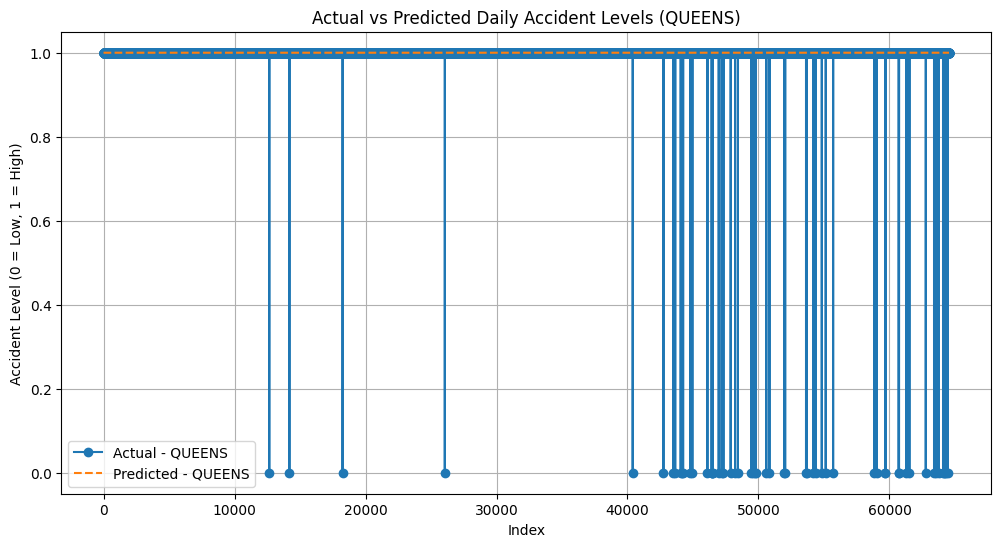

Visualizing results for borough: BROOKLYN


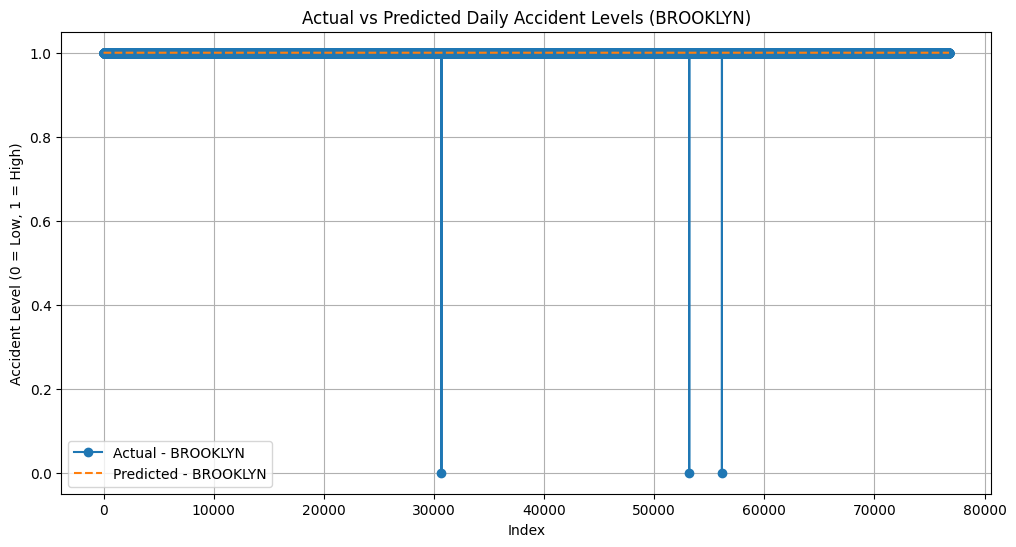

Visualizing results for borough: BRONX


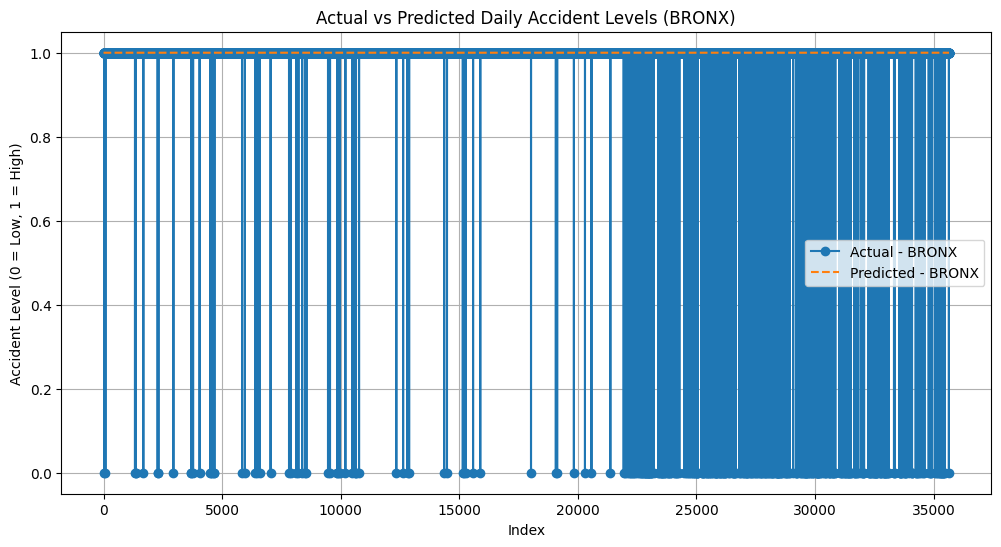

Visualizing results for borough: MANHATTAN


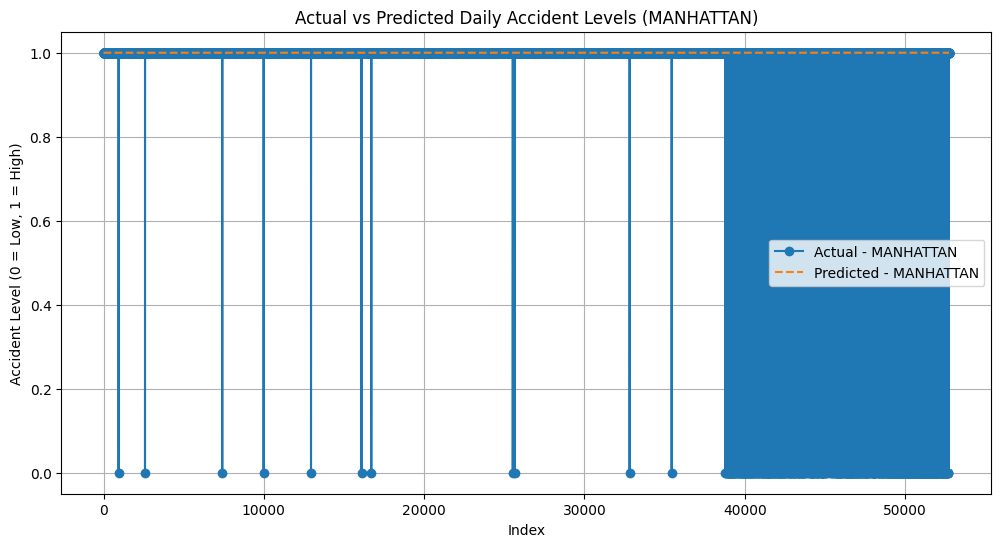

Visualizing results for borough: STATEN ISLAND


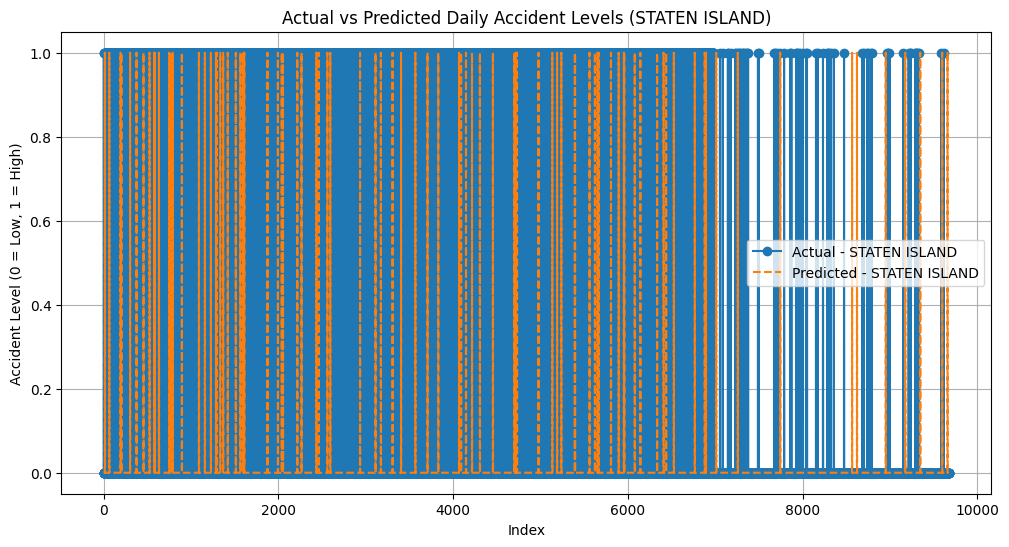

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

for borough_row in boroughs:
    borough_name = borough_row["borough"]
    print(f"Visualizing results for borough: {borough_name}")

    # Filter data for the current borough
    borough_data = data_with_features.filter(col("borough") == borough_name)

    # Split data into training and testing sets
    train_data, test_data = borough_data.randomSplit([0.8, 0.2], seed=42)

    # Generate predictions on the test data
    predictions = models[borough_name].transform(test_data)

    # Convert PySpark DataFrame to Pandas DataFrame for visualization
    comparison_df = predictions.select("label", "prediction").toPandas()

    # Aggregate actual and predicted values for plotting
    comparison_df["index"] = range(len(comparison_df))
    comparison_df["actual"] = comparison_df["label"]
    comparison_df["predicted"] = comparison_df["prediction"]

    # Plot Actual vs Predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(
        comparison_df["index"],
        comparison_df["actual"],
        label=f"Actual - {borough_name}",
        marker="o",
        linestyle="-"
    )
    plt.plot(
        comparison_df["index"],
        comparison_df["predicted"],
        label=f"Predicted - {borough_name}",
        linestyle="--"
    )
    plt.title(f"Actual vs Predicted Daily Accident Levels ({borough_name})")
    plt.xlabel("Index")
    plt.ylabel("Accident Level (0 = Low, 1 = High)")
    plt.legend()
    plt.grid()
    plt.show()


# Model Summary: Borough-Wise Accident Forecasting

## **Linear Regression (Weekly & Daily Forecasting)**

### Weekly Forecasting
- **Key Features:** Aggregated weather conditions (`avg_temp`, `avg_humidity`, etc.), time features (`crash_year`, `crash_week`), and borough-specific weights.
- **Results:**
  - **Evaluation Metrics:**
    - Queens: **MAE = 120.81, RMSE = 147.70**
    - Brooklyn: **MAE = 119.58, RMSE = 144.54**
    - Bronx: **MAE = 72.99, RMSE = 80.47**
    - Manhattan: **MAE = 105.47, RMSE = 133.86**
    - Staten Island: **MAE = 17.38, RMSE = 22.37**
- **Visualization:** Predicted vs. actual weekly accidents for each borough showed close alignment for larger boroughs like Brooklyn.

### Daily Forecasting
- **Key Features:** Temporal features (day-of-week, day-of-year), weather conditions, and categorical indexes.
- **Results:**
  - Evaluation metrics varied by borough; significant errors observed in Bronx predictions.
- **Visualization:** Predicted values aligned reasonably well with actual values, particularly in boroughs with smaller accident variability.

---

## **Random Forest (Weekly & Daily Forecasting)**

### Weekly Forecasting
- **Model Setup:** Random Forest with cross-validation, tuned for number of trees (`numTrees`) and maximum depth (`maxDepth`).
- **Results:**
  - Queens: **MAE = 182.71, RMSE = 205.65**
  - Brooklyn: **MAE = 190.04, RMSE = 212.87**
  - Bronx: **MAE = 100.02, RMSE = 108.00**
  - Manhattan: **MAE = 172.46, RMSE = 194.74**
  - Staten Island: **MAE = 24.35, RMSE = 30.41**
- **Observations:** Performed better for smaller boroughs with less variability, like Staten Island.

### Daily Forecasting
- **Key Features:** Temporal and weather features, including borough-specific indexes.
- **Results:**
  - Queens: **MAE = 6.83, RMSE = 8.64**
  - Brooklyn: **MAE = 8.67, RMSE = 10.77**
  - Bronx: **MAE = 7.30, RMSE = 8.78**
  - Manhattan: **MAE = 5.81, RMSE = 7.22**
  - Staten Island: **MAE = 2.24, RMSE = 2.88**

---

## **Gradient Boosting Trees (GBT)**

### Log-Transformed Features
- **Key Improvements:** Log-transformed weather features and lagged daily accident counts.
- **Results:**
  - Queens: **MAE = 4.13, RMSE = 8.24**
  - Brooklyn: **MAE = 5.30, RMSE = 9.86**
  - Bronx: **MAE = 4.99, RMSE = 8.52**
  - Manhattan: **MAE = 3.38, RMSE = 6.31**
  - Staten Island: **MAE = 1.37, RMSE = 2.59**
- **Observations:** Higher R-squared values for Manhattan and Staten Island indicated better fits; Bronx had higher variability.

---

## **Naive Bayes (Classification for High/Low Accident Days)**

- **Objective:** Binary classification of accident severity levels (`High (>20 accidents)` or `Low (<=20 accidents)`).
- **Key Features:** Scaled weather and spatial data, temporal factors (`month`, `day_of_week`), and borough-specific segmentation.
- **Results:**
  - **Accuracy by Borough:**
    - Queens: **99.91%**
    - Brooklyn: **100.00%**
    - Bronx: **98.91%**
    - Manhattan: **98.92%**
    - Staten Island: **66.74%**
- **Visualization:** Clear distinction between predicted and actual labels for boroughs with consistent trends; Staten Island showed lower performance due to fewer data points and higher variability.

---

## **Overall Observations and Recommendations**
1. **Best Performing Model:** GBT with log-transformed features achieved the lowest MAE/RMSE across most boroughs and handled temporal patterns effectively.
2. **Naive Bayes Strength:** Effective for binary classification tasks but struggled in nuanced predictions, particularly in Staten Island.
3. **Future Enhancements:**
   - Include external factors like traffic patterns or holidays.
   - Explore ensemble methods combining GBT and Random Forest for improved accuracy.
   - Test interaction terms and advanced feature engineering for highly variable boroughs (e.g., Bronx).
